## Plotting

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
from cea.config import Configuration
from cea_energy_hub_optimizer.my_config import MyConfig
from cea_energy_hub_optimizer.district import District
from cea_energy_hub_optimizer.timeseries import Demand
from trustParetoFronts.pareto_analysis import ParetoFront
from trustParetoFronts.pareto_front_plots import tech_size_boxplot, tech_cost_stackedbar
import trustParetoFronts.geometry_analysis as ga

config = MyConfig(Configuration())

# Plot settings
plt.rcParams["font.family"] = "Roboto"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["legend.loc"] = "lower center"
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titley"] = 1.03
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["xtick.major.width"] = 2  # setting the x-axis tick width globally
plt.rcParams["ytick.major.width"] = 2  # setting the y-axis tick width globally
# Set fig size
plt.rcParams["figure.figsize"] = (12, 8)

with_oil = False
if with_oil:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_with_oil",
    )
else:
    pareto_fronts_path = os.path.join(
        config.locator.get_optimization_results_folder(),
        "calliope_energy_hub",
        "batch_without_oil",
    )

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


### Prepare raw data

In [ ]:
def cluster_by_shadow_price_and_reduction_potential(x, y):
    if x < 0.2:
        return 0
    elif y < -100 / 3 * x + 120:
        return 1
    else:
        return 2


def get_geometry_values(gdf: gpd.GeoDataFrame):
    gdf["elongation"] = gdf["geometry"].apply(ga.calculate_elongation)
    gdf["shape_factor"] = gdf.apply(
        lambda row: ga.calculate_shape_factor(row["geometry"], row["height_ag"]), axis=1
    )
    gdf["concavity"] = gdf["geometry"].apply(ga.calculate_concavity)
    gdf["compactness"] = gdf.apply(
        lambda row: ga.calculate_compactness(row["geometry"], row["height_ag"]), axis=1
    )
    gdf["direction"] = gdf["geometry"].apply(ga.calculate_building_direction)
    return gdf


total_demand = pd.read_csv(config.locator.get_total_demand(), index_col=0)
# prepare data
zone_path = config.locator.get_zone_geometry()
typology_path = config.locator.get_building_typology()
emission_systems_path = config.locator.get_building_air_conditioning()

zone_gdf: gpd.GeoDataFrame = gpd.read_file(zone_path)
zone_gdf["floor_area"] = zone_gdf.geometry.area
zone_gdf = get_geometry_values(zone_gdf)
zone_df = pd.DataFrame(zone_gdf).drop(columns="geometry").set_index("Name")
typology_df: pd.DataFrame = gpd.read_file(
    typology_path, ignore_geometry=True
).set_index("Name")
emission_system_df: pd.DataFrame = gpd.read_file(
    emission_systems_path, ignore_geometry=True
).set_index("Name")
zone_df = pd.concat([zone_df, typology_df, emission_system_df], axis=1, join="inner")
zone_df["area"] = zone_df["floor_area"] * zone_df["floors_ag"]
zone_df.drop(
    columns=[
        "floors_bg",
        "height_bg",
        "type_cs",
        "type_dhw",
        "heat_starts",
        "heat_ends",
        "cool_starts",
        "cool_ends",
        # "1ST_USE",
        "1ST_USE_R",
        "2ND_USE",
        "2ND_USE_R",
        "3RD_USE",
        "3RD_USE_R",
    ],
    inplace=True,
)
del zone_gdf, typology_df, emission_system_df

df_pareto_dict = {}
cost_per_tech_dict = {}
for building_name, row in zone_df.iterrows():
    area = float(row["area"])
    csv_name = os.path.join(pareto_fronts_path, f"{building_name}_pareto.csv")
    if not os.path.exists(csv_name):
        zone_df.drop(index=building_name, inplace=True)
        continue
    df_pareto = pd.read_csv(
        csv_name,
        index_col=[0, 1],
    )
    df_pareto_dict[building_name] = df_pareto
    emissions: np.array = df_pareto.loc[building_name, "emission"].values / area
    costs: np.array = df_pareto.loc[building_name, "cost"].values / area
    pf = ParetoFront(np.round(emissions, 3), np.round(costs, 3))
    zone_df.loc[building_name, "shadow_price"] = 1 / pf.slope()
    zone_df.loc[building_name, "pf_curvature"] = pf.curvature()
    zone_df.loc[building_name, "emission_range_abs"] = pf.x_range()
    zone_df.loc[building_name, "cost_range"] = pf.y_range()
    zone_df.loc[building_name, "emission_range_rel"] = pf.x_range(rel=True)
    # sh, ee, ww = get_demand_intensity(building_name, area)
    sh = total_demand.loc[building_name, "Qhs_sys_MWhyr"] * 1000 / area
    ee = total_demand.loc[building_name, "E_sys_MWhyr"] * 1000 / area
    ww = total_demand.loc[building_name, "Qww_sys_MWhyr"] * 1000 / area
    if row["type_hs"] == "HVAC_HEATING_AS1":
        sh_peak = df_pareto.loc[building_name, "demand_space_heating_85"].values[0]
    else:
        sh_peak = df_pareto.loc[building_name, "demand_space_heating_35"].values[0]

    # ww_peak = df_pareto.loc[building_name, "demand_hot_water"].values[0]
    # ee_peak = df_pareto.loc[building_name, "demand_electricity"].values[0]
    # people_intensity = total_demand.loc[building_name, "people0"] / area
    zone_df.loc[building_name, "demand_space_heating_intensity"] = float(
        sh
    )  # in kWh/m2yr
    zone_df.loc[building_name, "demand_electricity_intensity"] = float(
        ee
    )  # in kWh/m2yr
    zone_df.loc[building_name, "demand_hot_water_intensity"] = float(ww)  # in kWh/m2yr
    # zone_df.loc[building_name, "people_intensity"] = float(people_intensity)  # in p/m2
    zone_df.loc[building_name, "peak_space_heating_demand"] = float(sh_peak)  # in kW
    # zone_df.loc[building_name, "peak_electricity_demand"] = float(ee_peak)  # in kW
    # zone_df.loc[building_name, "peak_hot_water_demand"] = float(ww_peak)  # in kW
    cluster = cluster_by_shadow_price_and_reduction_potential(
        1 / pf.slope(), pf.x_range(rel=True) * 100
    )
    zone_df.loc[building_name, "cluster"] = cluster

    cost_per_tech_path = os.path.join(
        pareto_fronts_path, f"{building_name}_cost_per_tech.csv"
    )
    if not os.path.exists(cost_per_tech_path):
        continue
    df_cost_per_tech = (
        pd.read_csv(cost_per_tech_path, index_col=[0, 1, 2])
        / zone_df.loc[building_name, "area"]
    )
    cost_per_tech_dict[building_name] = df_cost_per_tech

df_pareto_all = pd.concat(df_pareto_dict.values())
df_cost_per_tech_all = pd.concat(cost_per_tech_dict.values())

demand_color_dict = {
    "demand_space_heating_35": "gold",
    "demand_space_heating_85": "tab:red",
    "demand_hot_water": "tab:orange",
    "demand_electricity": "tab:green",
}

ls_supply_name = df_pareto_all.columns.difference(
    list(demand_color_dict.keys())
    + ["emission", "cost", "demand_space_heating_60", "demand_space_cooling"]
)
if not with_oil:
    ls_supply_name = ls_supply_name.difference(
        ["oil", "oil_boiler_large", "oil_boiler_middle", "oil_boiler_small"]
    )
df_pareto_all = df_pareto_all.merge(zone_df, left_on="building", right_index=True)
df_cost_per_tech_all = df_cost_per_tech_all[ls_supply_name]

In [ ]:
from trustParetoFronts.maximal_emission_reduction_dp import (
    maximal_emission_reduction_dp,
)

minimal_cost = df_pareto_all.groupby("building")["cost"].min().sum()
print(f"Minimal cost: {minimal_cost}")
maximal_cost = df_pareto_all.groupby("building")["cost"].max().sum()
print(f"Maximal cost: {maximal_cost}")

costs = []
emission_reductions = []

for cost in np.linspace(minimal_cost + 10000, maximal_cost - 10000, 100):
    _, emission_reduction, actual_cost = maximal_emission_reduction_dp(
        df_pareto_all, cost, precision=-2
    )
    costs.append(actual_cost)
    emission_reductions.append(emission_reduction)
    print(f"Cost: {actual_cost}, Emission reduction: {emission_reduction}")

plt.plot(costs, emission_reductions)
plt.show()

Minimal cost: 28459818.35119792
Maximal cost: 32423309.309756014
Cost: 28469818.35119792, Emission reduction: 179843.69414661598
Cost: 28509651.59320356, Emission reduction: 512774.46948829043
Cost: 28549484.835209195, Emission reduction: 714577.5831810961
Cost: 28589318.077214833, Emission reduction: 877127.6652357576
Cost: 28629151.31922047, Emission reduction: 1015158.4333850562
Cost: 28668984.561226107, Emission reduction: 1135345.2406564322
Cost: 28708817.803231746, Emission reduction: 1244483.4167264134
Cost: 28748651.04523738, Emission reduction: 1347556.060361962
Cost: 28788484.28724302, Emission reduction: 1444280.3509222155
Cost: 28828317.529248655, Emission reduction: 1535527.671050378
Cost: 28868150.771254294, Emission reduction: 1621392.2915277868
Cost: 28907984.013259932, Emission reduction: 1703252.3153653287
Cost: 28947817.255265567, Emission reduction: 1781259.9745781596
Cost: 28987650.497271206, Emission reduction: 1855233.1459370162
Cost: 29027483.73927684, Emission 

### fig1: Pareto Space plot

(0.1459238902307785, 9.534611735399281)


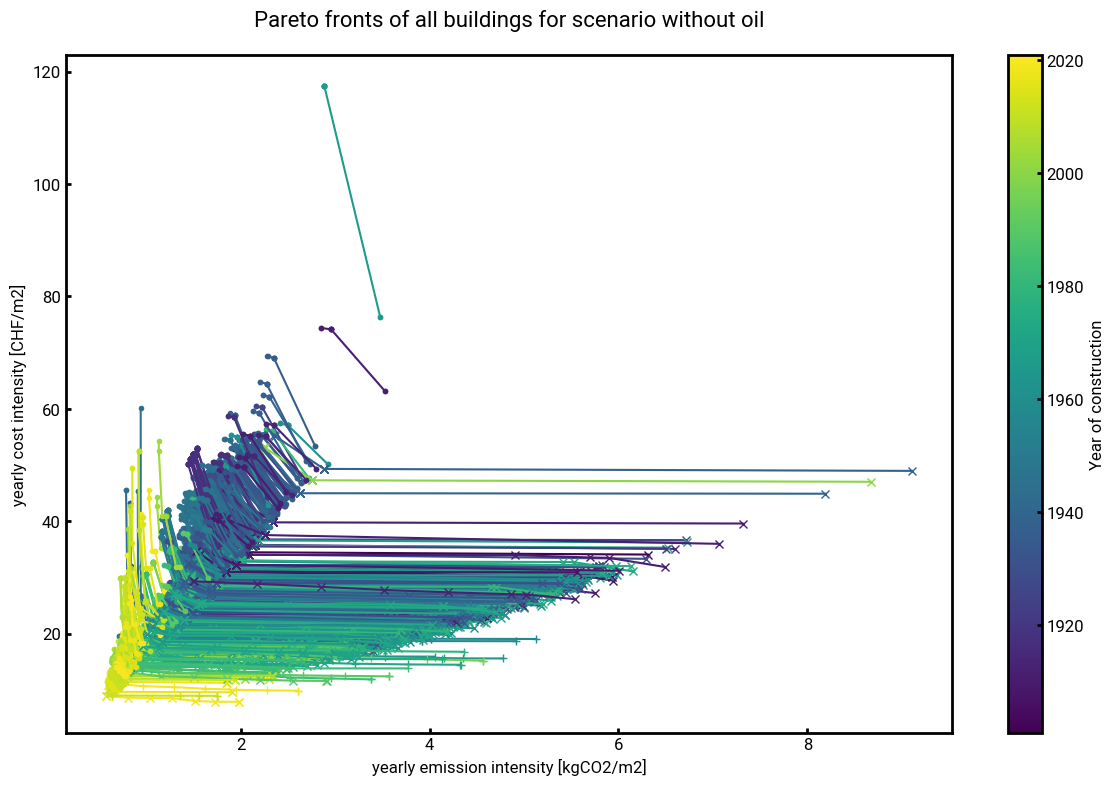

In [3]:
cluster_markers = {
    0: ".",
    1: "x",
    2: "+",
}
fig1, ax1 = plt.subplots()
year_min = df_pareto_all["YEAR"].min()
year_max = df_pareto_all["YEAR"].max()
year_norm = mcolors.Normalize(vmin=year_min, vmax=year_max)
colormap = plt.get_cmap("viridis")  # type: ignore
for building_name in df_pareto_all.index.get_level_values(0).unique():
    df_pareto = df_pareto_all.loc[building_name]
    # pareto front has two levels of index, the first one is the building name and second one is the pareto front number starting from 0
    emissions = df_pareto["emission"].values
    costs = df_pareto["cost"].values
    area = df_pareto[
        "area"
    ].mean()  # area is the same for all pareto fronts of the same building
    cluster = df_pareto["cluster"].iloc[0]
    ax1.plot(
        emissions / area,
        costs / area,
        label=building_name,
        marker=cluster_markers[cluster],
        color=colormap(year_norm(zone_df["YEAR"].loc[building_name])),
    )
cbar1 = fig1.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=ax1, orientation="vertical")  # type: ignore
cbar1.set_label("Year of construction")
ax1.set_xlabel("yearly emission intensity [kgCO2/m2]")
ax1.set_ylabel("yearly cost intensity [CHF/m2]")
print(ax1.get_xlim())
if with_oil:
    ax1.set_title("Pareto fronts of all buildings for scenario with oil")
else:
    ax1.set_title("Pareto fronts of all buildings for scenario without oil")
fig1.tight_layout()

### fig2: emission reduction potential against shadow price

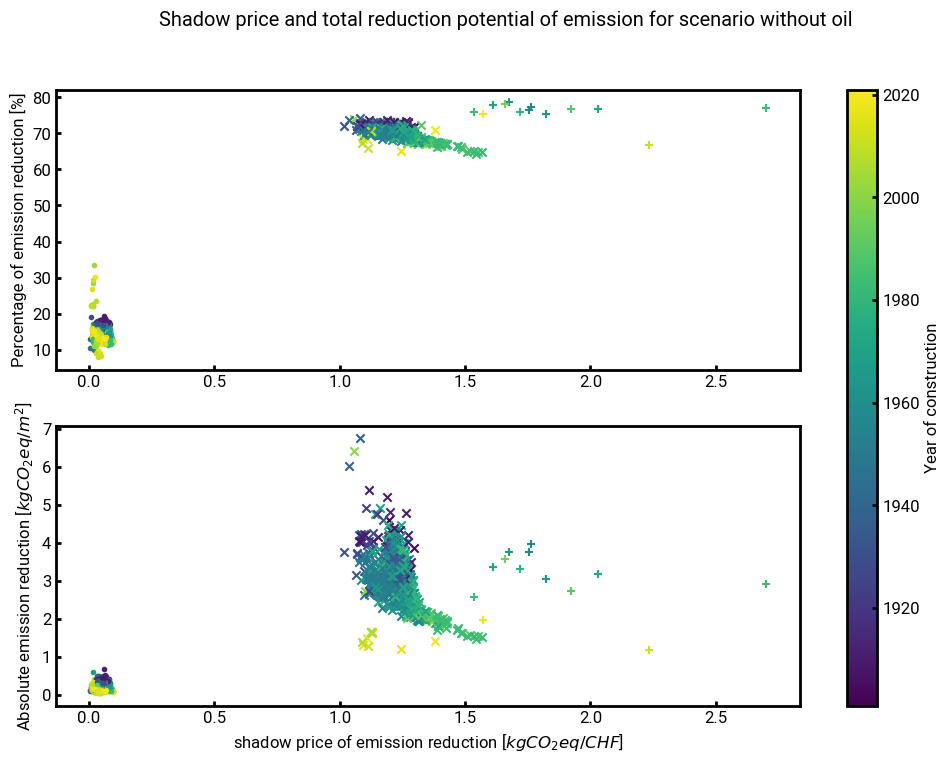

In [4]:
fig2, axes = plt.subplots(2, 1)
for idx, ax in enumerate(axes):
    for building_name in df_pareto_all.index.get_level_values(0).unique():
        df_pareto = df_pareto_all.loc[building_name]
        emissions = df_pareto["emission"].values
        costs = df_pareto["cost"].values
        area = df_pareto["area"].iloc[
            0
        ]  # area is the same for all pareto fronts of the same building
        cluster = df_pareto["cluster"].iloc[0]
        dx = df_pareto["shadow_price"].iloc[0]
        if idx == 0:  # plotting relative emission reduction
            dy = df_pareto["emission_range_rel"].iloc[0] * 100
            ax.set_ylabel("Percentage of emission reduction [%]")
        else:  # idx=1, second subplot, plotting absolute emission reduction
            dy = df_pareto["emission_range_abs"].iloc[0]
            ax.set_ylabel("Absolute emission reduction [$kgCO_2eq/m^2$]")

        building_year = df_pareto["YEAR"].iloc[0]
        building_color = colormap(year_norm(building_year))
        ax.scatter(dx, dy, marker=cluster_markers[cluster], color=building_color)

axes[0].sharex(axes[1])
axes[1].set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
# axes[0].set_xlim(0, 10)
cbar2 = fig2.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=year_norm), ax=axes, orientation="vertical")  # type: ignore
cbar2.set_label("Year of construction")
if with_oil:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario with oil"
    )
else:
    fig2.suptitle(
        "Shadow price and total reduction potential of emission for scenario without oil"
    )

### fig3: tech size box plot

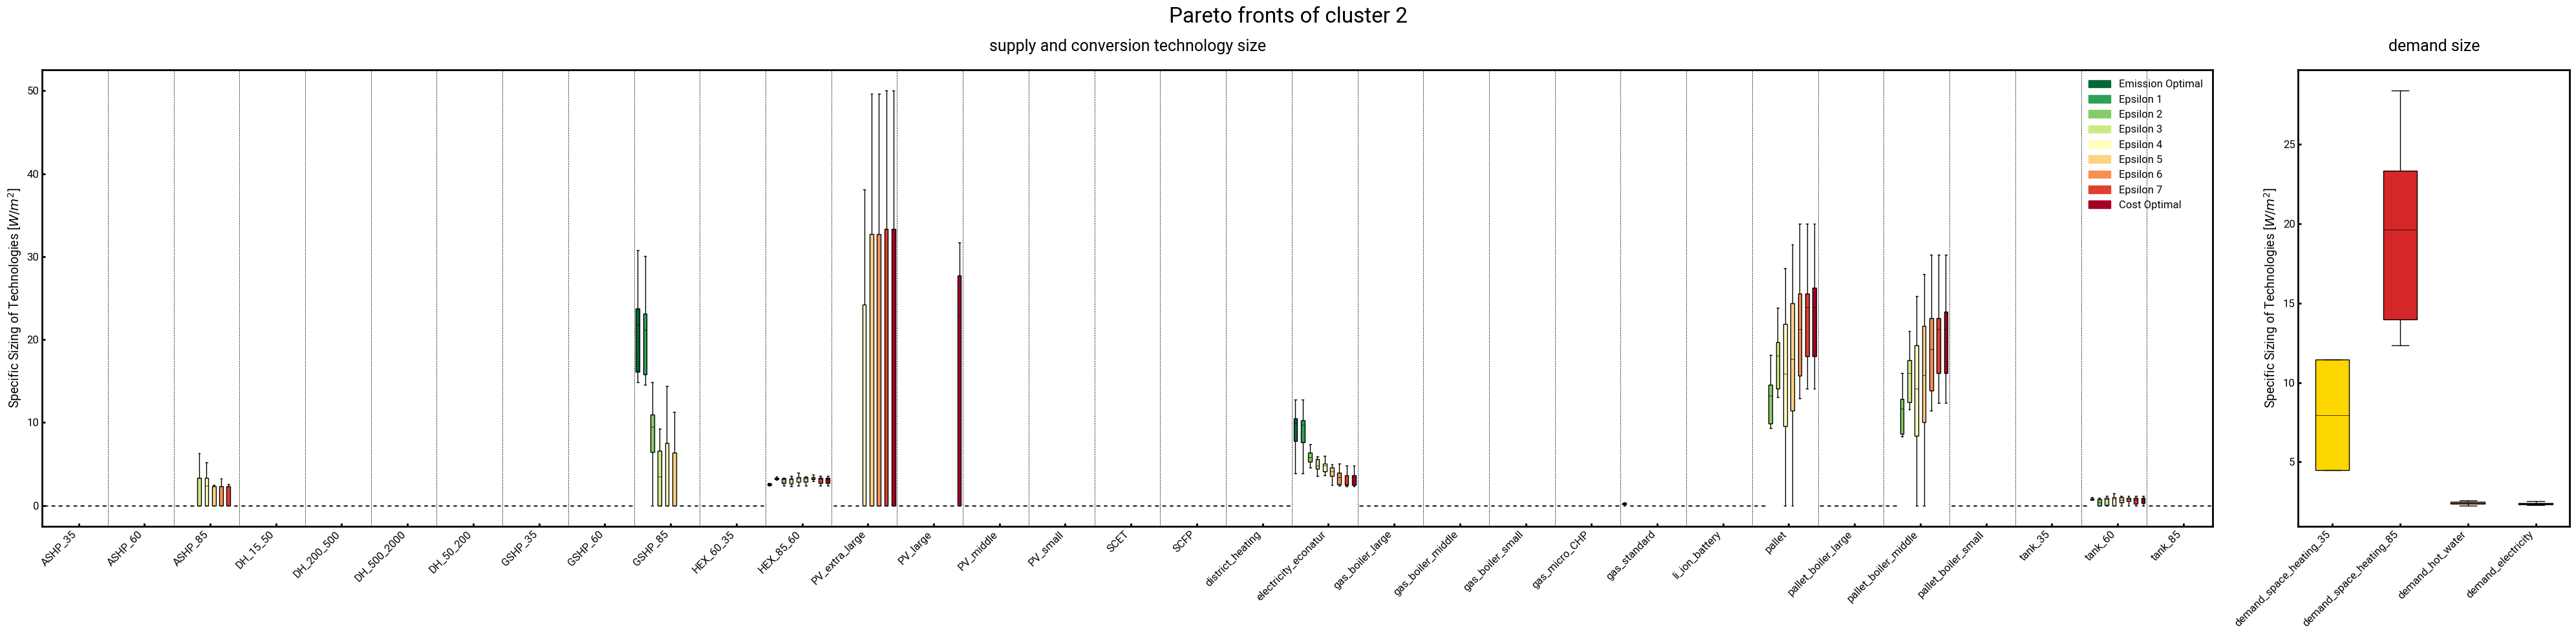

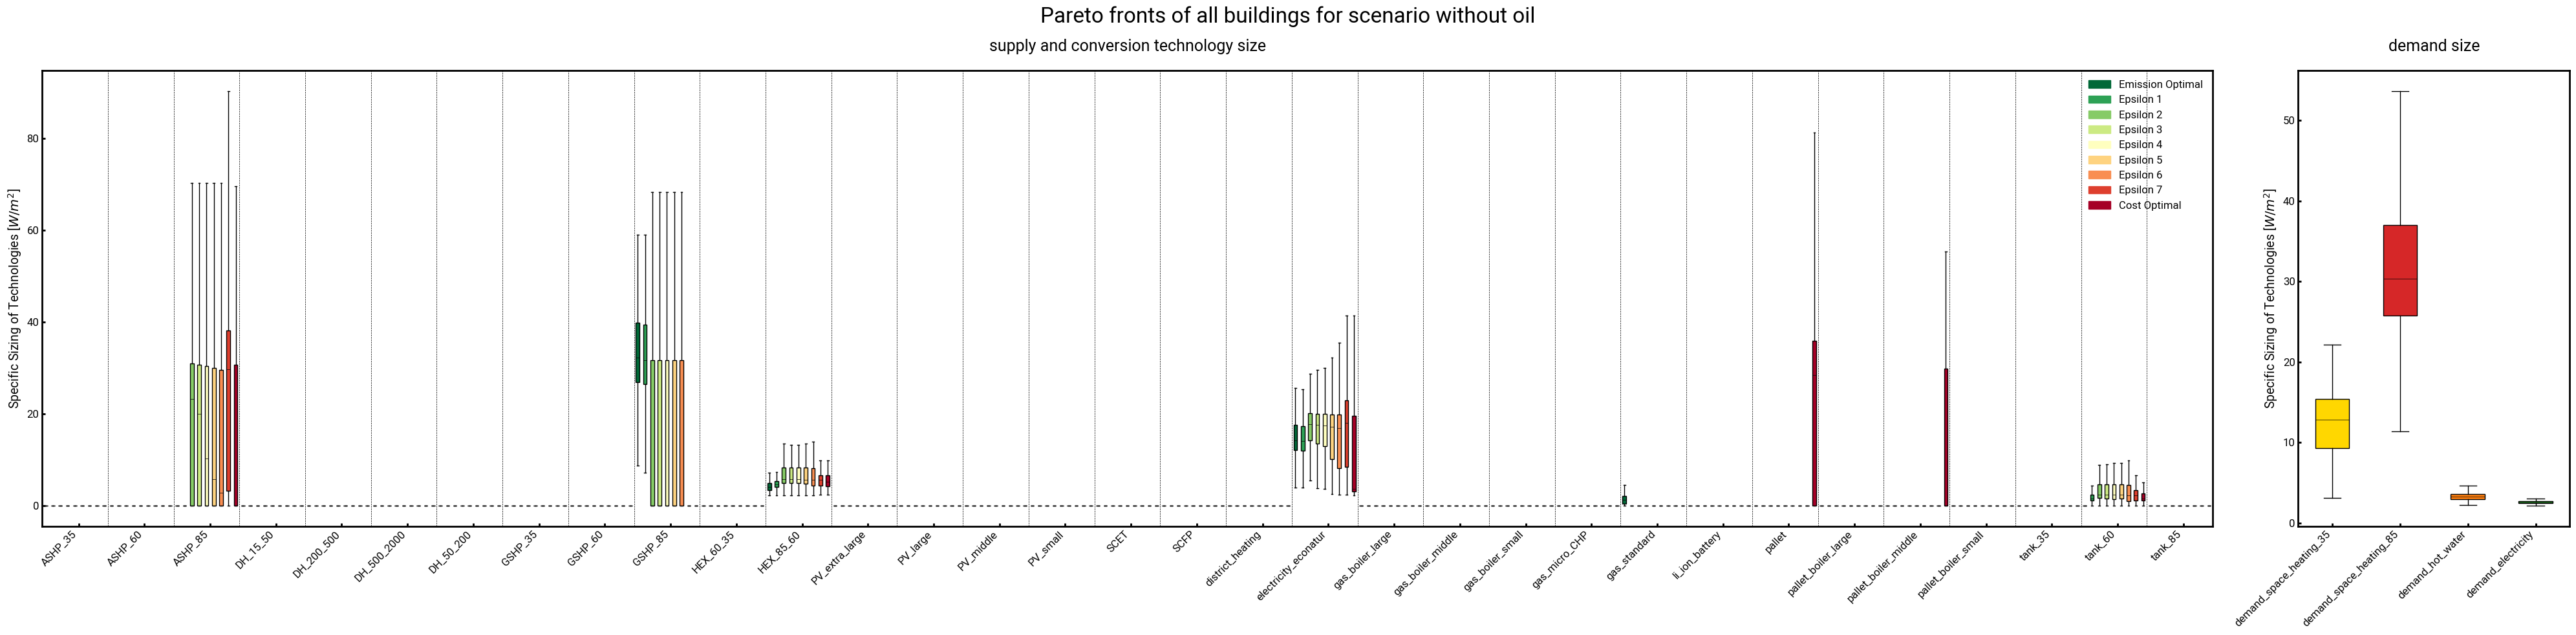

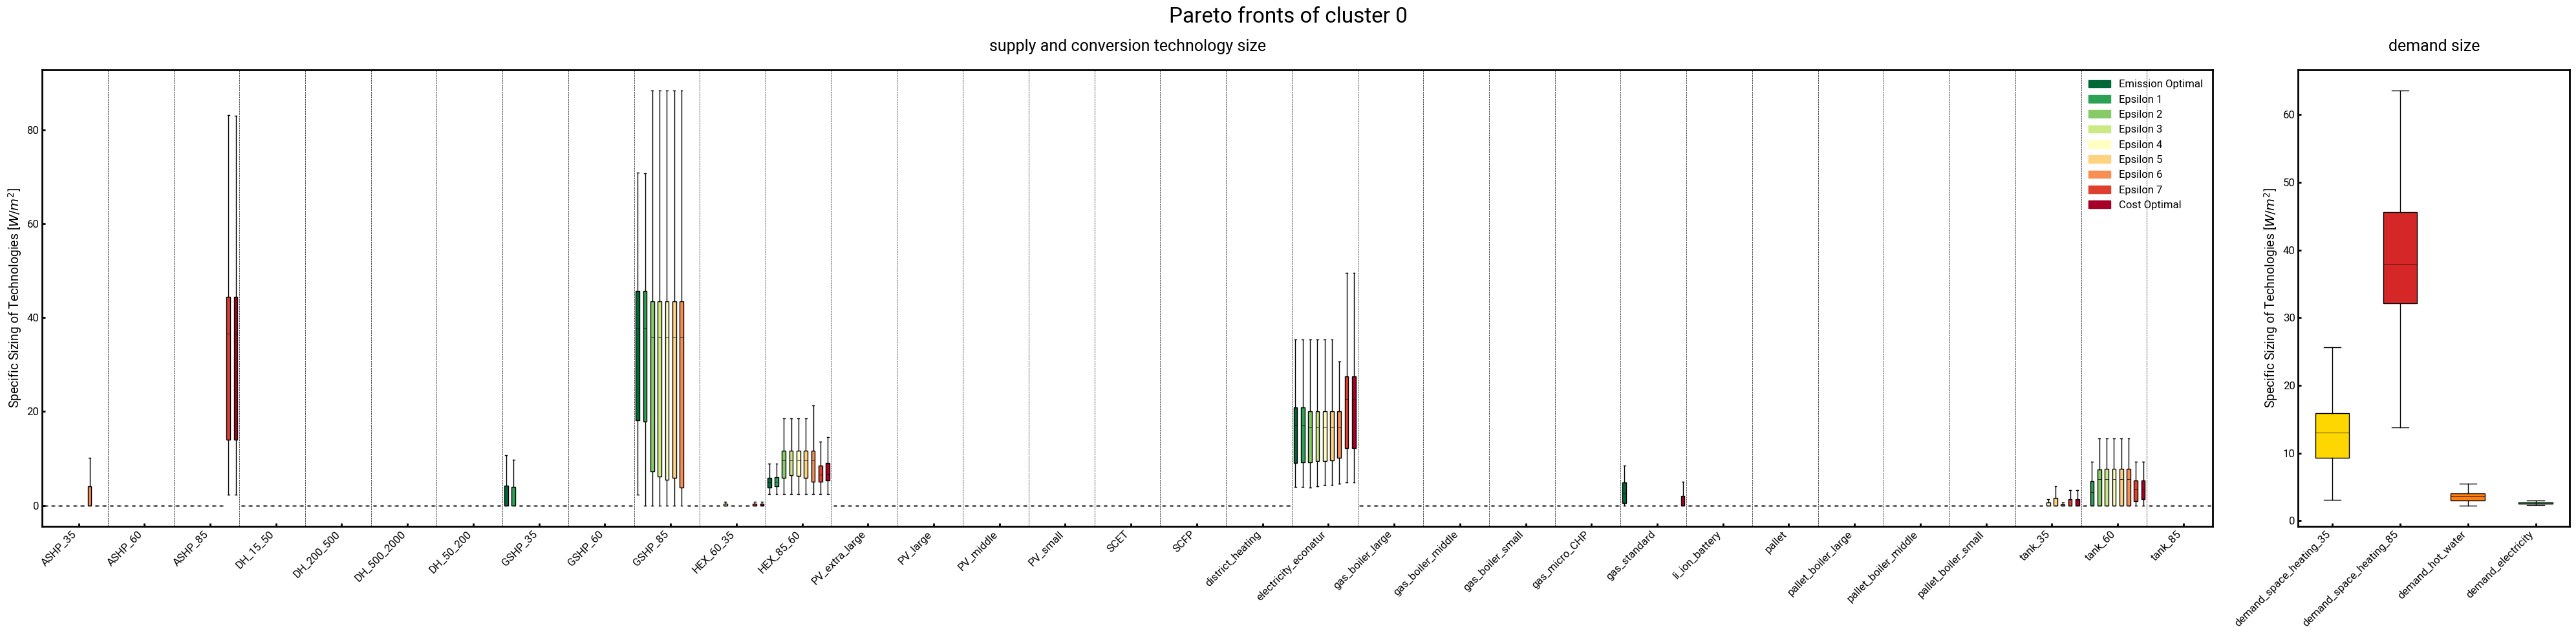

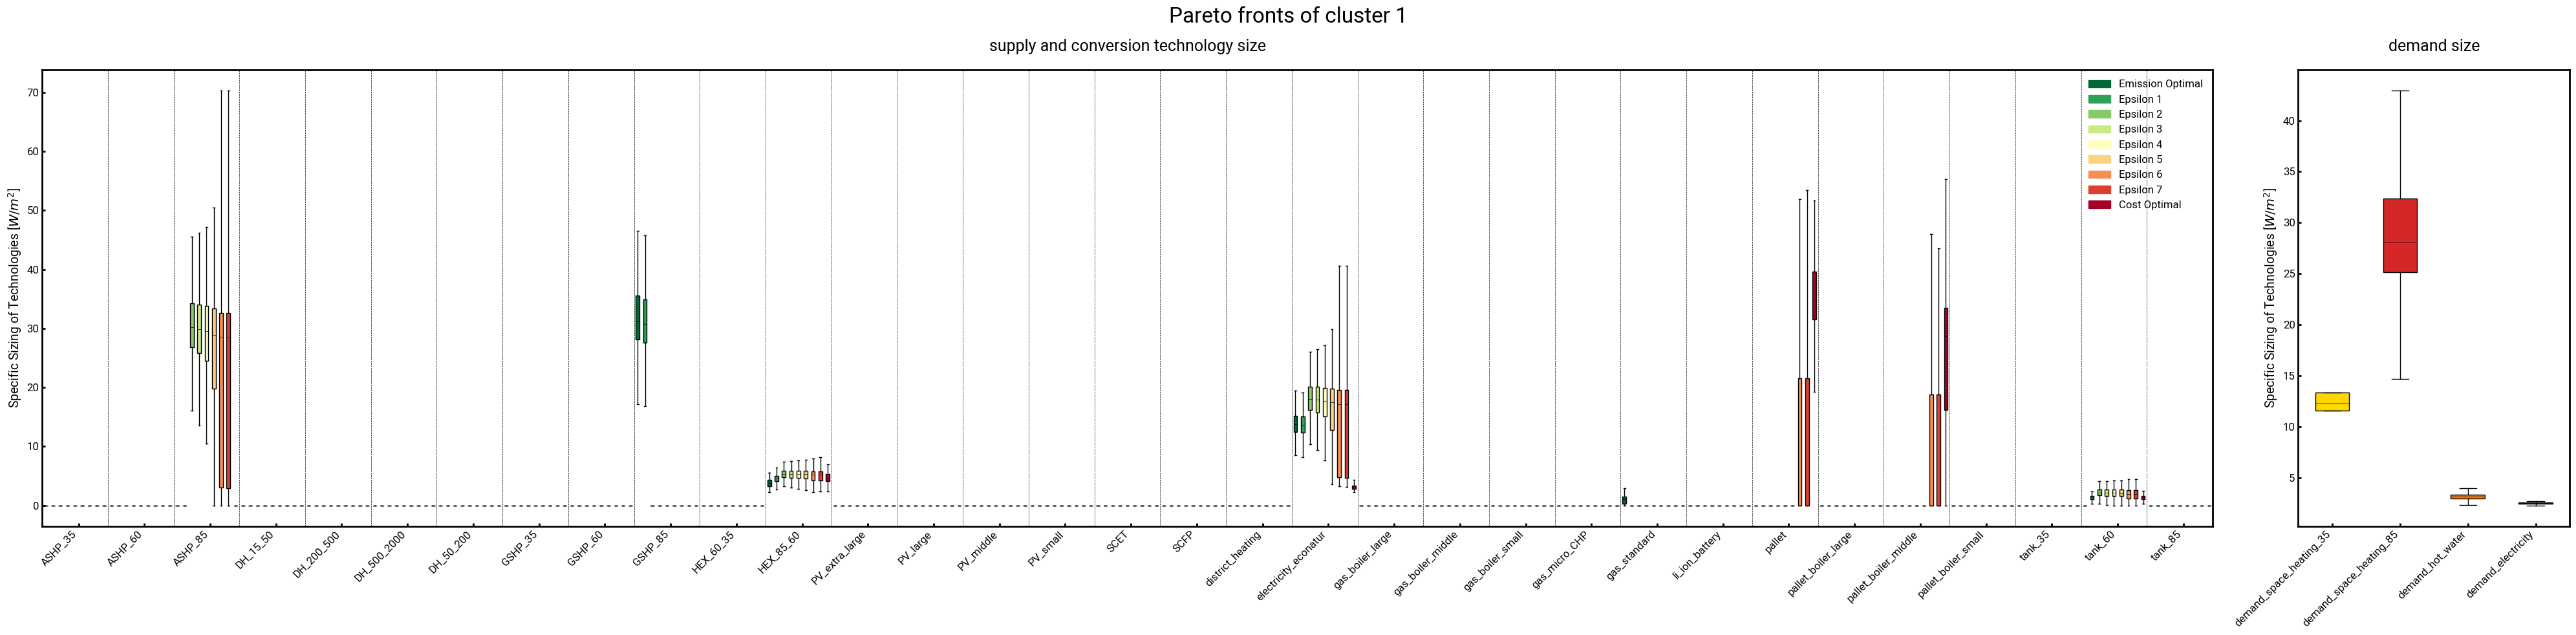

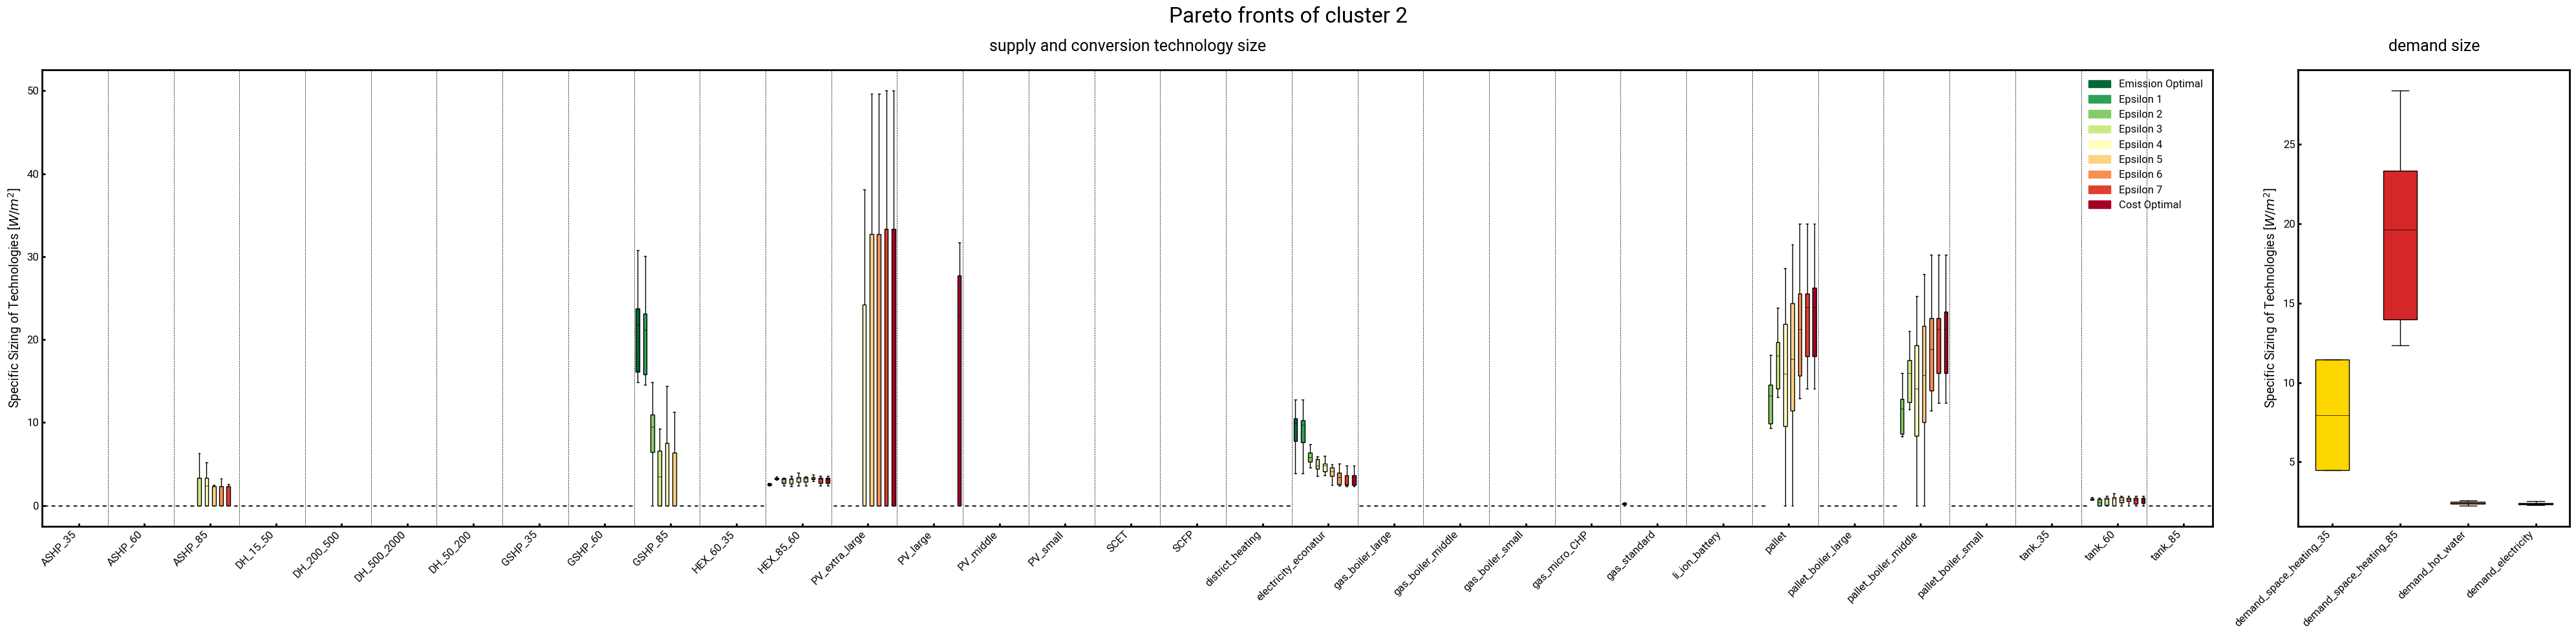

In [5]:
if with_oil:
    title_3 = "Pareto fronts of all buildings for scenario with oil"
else:
    title_3 = "Pareto fronts of all buildings for scenario without oil"
tech_size_boxplot(
    df_pareto_all,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig=title_3,
    figsize=(40, 10),
    width_ratios=(8, 1),
)

df_pareto_0 = df_pareto_all[df_pareto_all["cluster"] == 0]
df_pareto_1 = df_pareto_all[df_pareto_all["cluster"] == 1]
df_pareto_2 = df_pareto_all[df_pareto_all["cluster"] == 2]

tech_size_boxplot(
    df_pareto_0,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 0",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_1,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 1",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_size_boxplot(
    df_pareto_2,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Pareto fronts of cluster 2",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

### fig4: cost distribution stacked bar plot

In [6]:
tech_colors = {
    "ASHP_35": "#89CFF0",  # Light Blue
    "ASHP_60": "#5B92E5",  # Medium Blue
    "ASHP_85": "#2A57B7",  # Dark Blue
    "DH_15_50": "#FFB347",  # Soft Orange
    "DH_200_500": "#FF8C42",  # Vibrant Orange
    "DH_500_2000": "#FF5F1F",  # Dark Orange
    "DH_50_200": "#FFA07A",  # Salmon Orange
    "GSHP_35": "#98FB98",  # Pale Green
    "GSHP_60": "#32CD32",  # Lime Green
    "GSHP_85": "#228B22",  # Forest Green
    "HEX_60_35": "#DDA0DD",  # Light Purple
    "HEX_85_60": "#9932CC",  # Dark Purple
    "PV_extra_large": "#FFD700",  # Gold
    "PV_large": "#FFC300",  # Deep Yellow
    "PV_middle": "#FFA500",  # Orange-Yellow
    "PV_small": "#FFD580",  # Light Yellow
    "SCET": "#FFA07A",  # Salmon
    "SCFP": "#FF4500",  # Orange-Red
    "district_heating": "#FF6347",  # Tomato Red
    "electricity_econatur": "#00CED1",  # Dark Turquoise
    "gas_boiler_large": "#A52A2A",  # Brown
    "gas_boiler_middle": "#8B4513",  # Saddle Brown
    "gas_boiler_small": "#D2691E",  # Chocolate
    "gas_micro_CHP": "#CD853F",  # Peru
    "gas_standard": "#8B0000",  # Dark Red
    "li_ion_battery": "#708090",  # Slate Grey
    "oil": "#2F4F4F",  # Dark Slate Grey
    "oil_boiler_large": "#696969",  # Dim Grey
    "oil_boiler_middle": "#A9A9A9",  # Dark Grey
    "oil_boiler_small": "#D3D3D3",  # Light Grey
    "pallet": "#DEB887",  # Burlywood
    "pallet_boiler_large": "#BC8F8F",  # Rosy Brown
    "pallet_boiler_middle": "#F4A460",  # Sandy Brown
    "pallet_boiler_small": "#DAA520",  # Goldenrod
    "tank_35": "#4682B4",  # Steel Blue
    "tank_60": "#5F9EA0",  # Cadet Blue
    "tank_85": "#2E8B57",  # Sea Green
}

In [7]:
per_tech_cost_0_dict = {}
per_tech_cost_1_dict = {}
per_tech_cost_2_dict = {}
for building_name, row in zone_df.iterrows():
    df_cost_per_tech = cost_per_tech_dict.get(building_name)
    if df_cost_per_tech is None:
        continue
    cluster = zone_df.loc[building_name, "cluster"]
    df_cost_per_tech.drop(
        columns=[
            "demand_space_heating_35",
            "demand_space_heating_60",
            "demand_space_heating_85",
            "demand_space_cooling",
            "demand_hot_water",
            "demand_electricity",
        ],
        inplace=True,
    )
    if cluster == 0:
        per_tech_cost_0_dict[building_name] = df_cost_per_tech
    elif cluster == 1:
        per_tech_cost_1_dict[building_name] = df_cost_per_tech
    else:
        per_tech_cost_2_dict[building_name] = df_cost_per_tech
df_cost_per_tech_0 = pd.concat(per_tech_cost_0_dict.values())
df_cost_per_tech_1 = pd.concat(per_tech_cost_1_dict.values())
df_cost_per_tech_2 = pd.concat(per_tech_cost_2_dict.values())

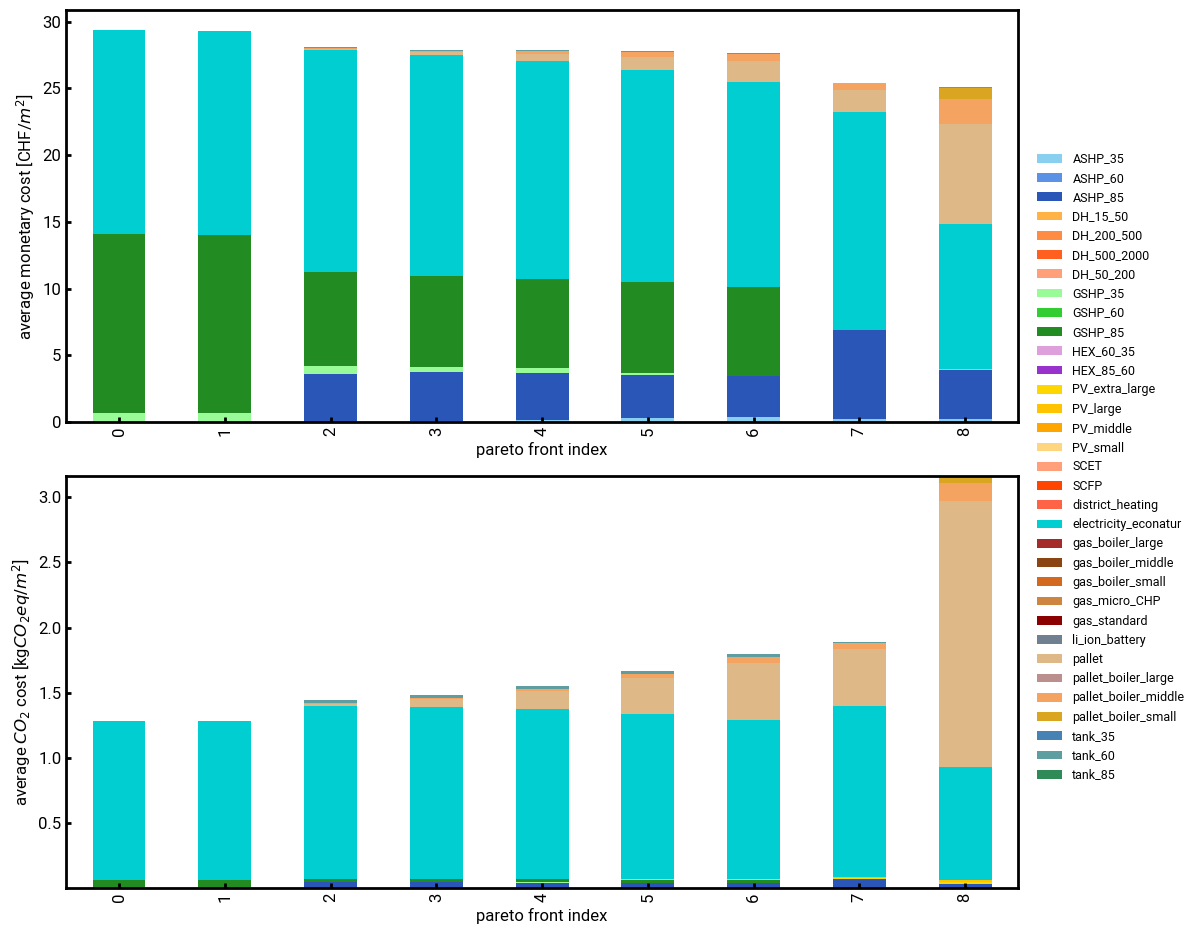

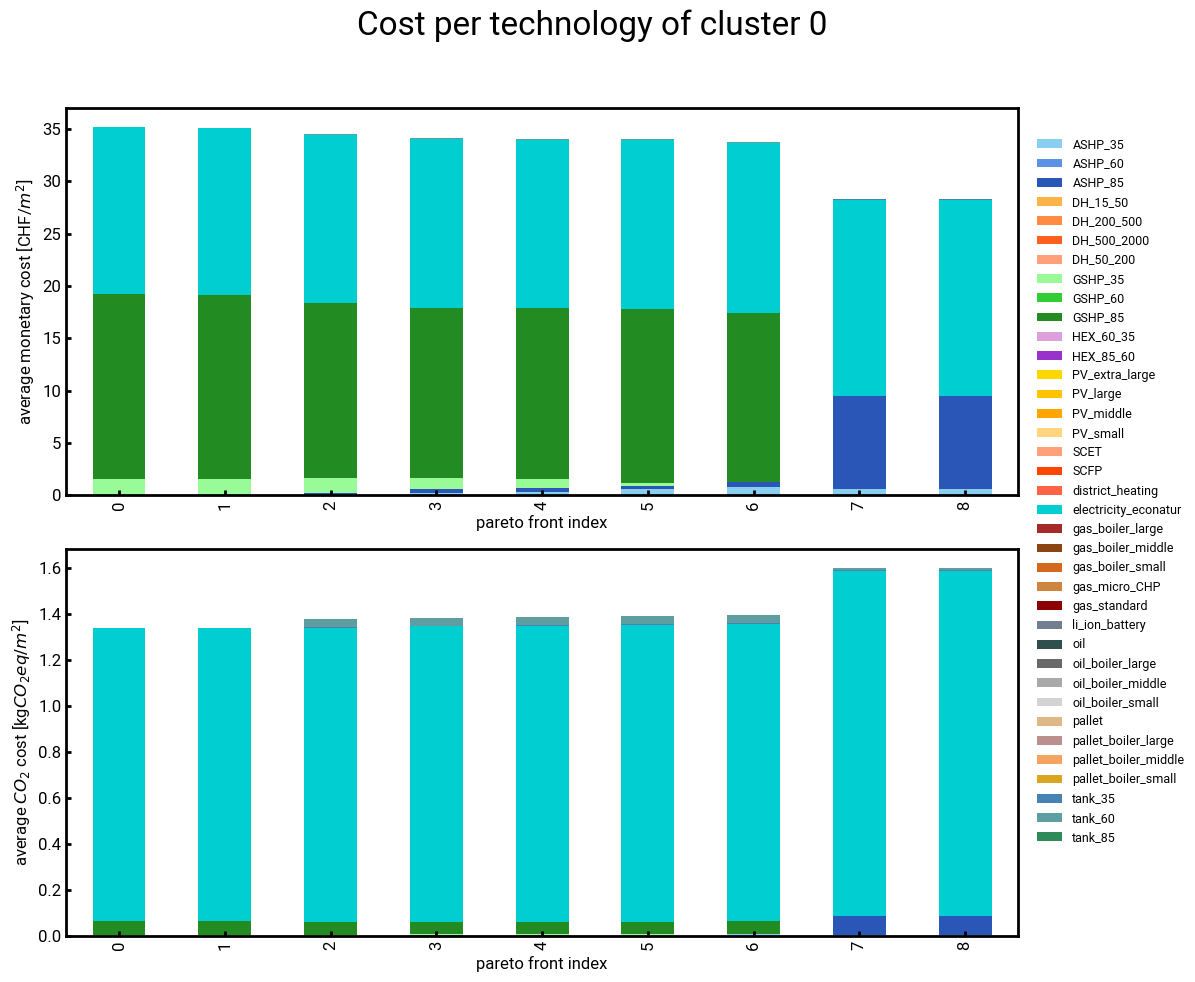

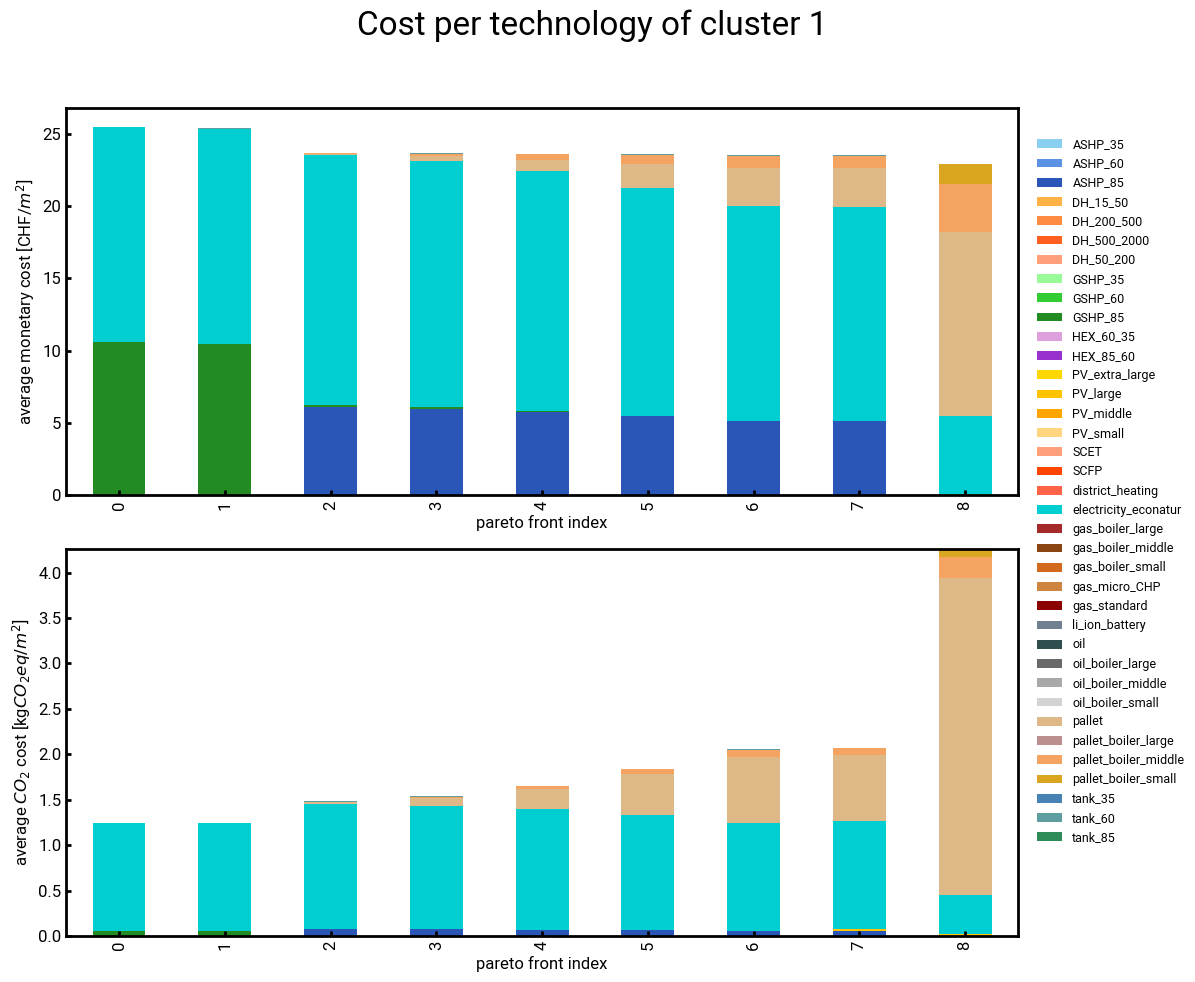

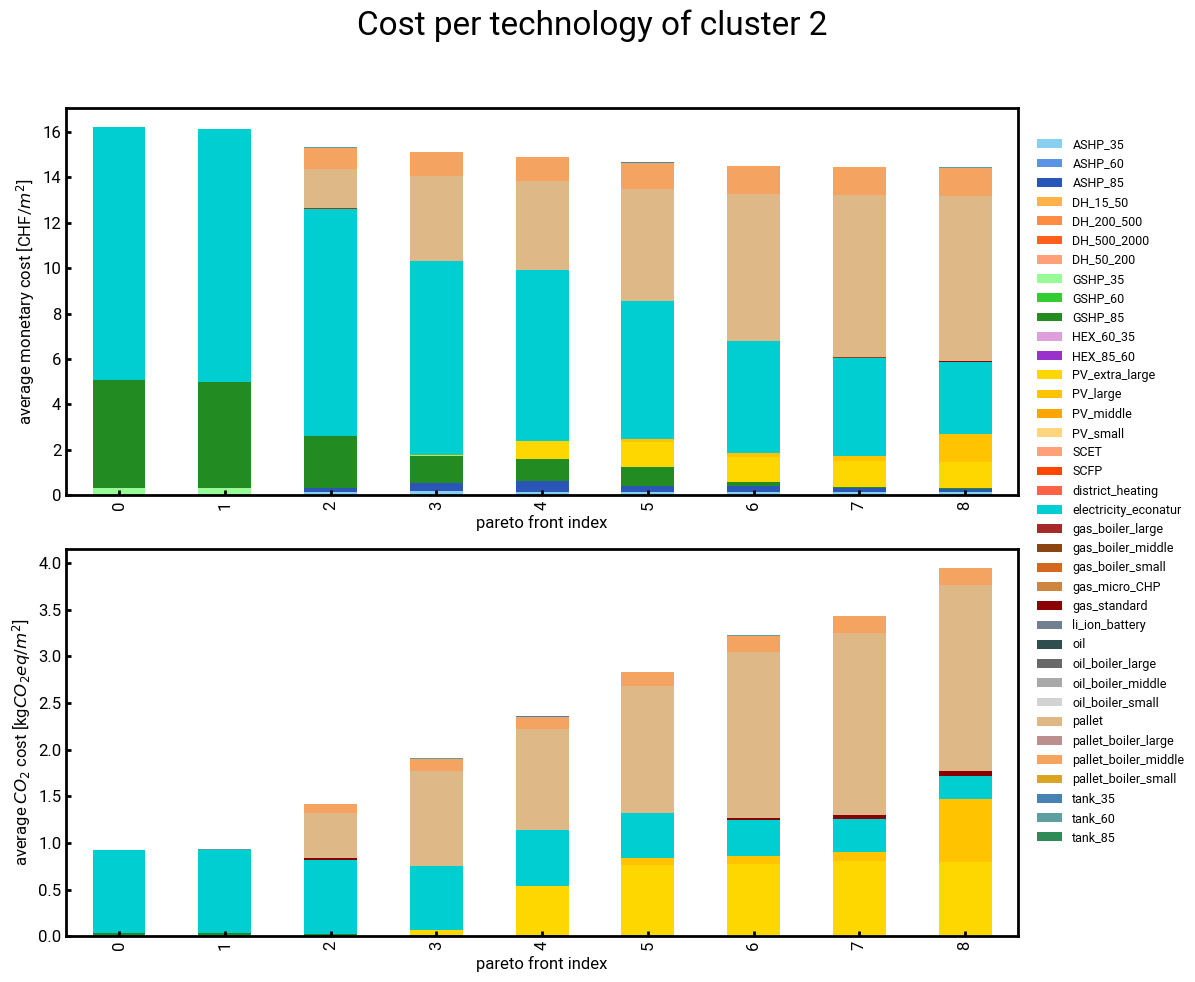

In [8]:
tech_cost_stackedbar(
    df_cost_per_tech_all,
    tech_colors,
    figsize=(12, 10),
)

tech_cost_stackedbar(
    df_cost_per_tech_0,
    tech_colors,
    title="Cost per technology of cluster 0",
    figsize=(12, 10),
)

tech_cost_stackedbar(
    df_cost_per_tech_1,
    tech_colors,
    title="Cost per technology of cluster 1",
    figsize=(12, 10),
)

tech_cost_stackedbar(
    df_cost_per_tech_2,
    tech_colors,
    title="Cost per technology of cluster 2",
    figsize=(12, 10),
)

### fig5: tech size and cost distribution, but for collided pareto points

In [13]:
# identify collided points
df_pareto_collided_only = df_pareto_all[
    df_pareto_all.duplicated(subset=["emission", "cost"], keep=False)
]
df_pareto_collided = df_pareto_all.copy()
df_pareto_collided.loc[:, :] = 0
df_pareto_collided.loc[df_pareto_collided_only.index, :] = df_pareto_collided_only

df_cost_index_two_level = df_cost_per_tech_all.index.droplevel(2)
mask = df_cost_index_two_level.isin(df_pareto_collided_only.index)
df_cost_per_tech_collided_only = df_cost_per_tech_all[mask]

df_cost_per_tech_collided = df_cost_per_tech_all.copy()
df_cost_per_tech_collided.loc[:, :] = 0
df_cost_per_tech_collided.loc[df_cost_per_tech_collided_only.index, :] = (
    df_cost_per_tech_collided_only
)

C:\Users\wangy\AppData\Local\Temp\ipykernel_25432\2481841626.py:6: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



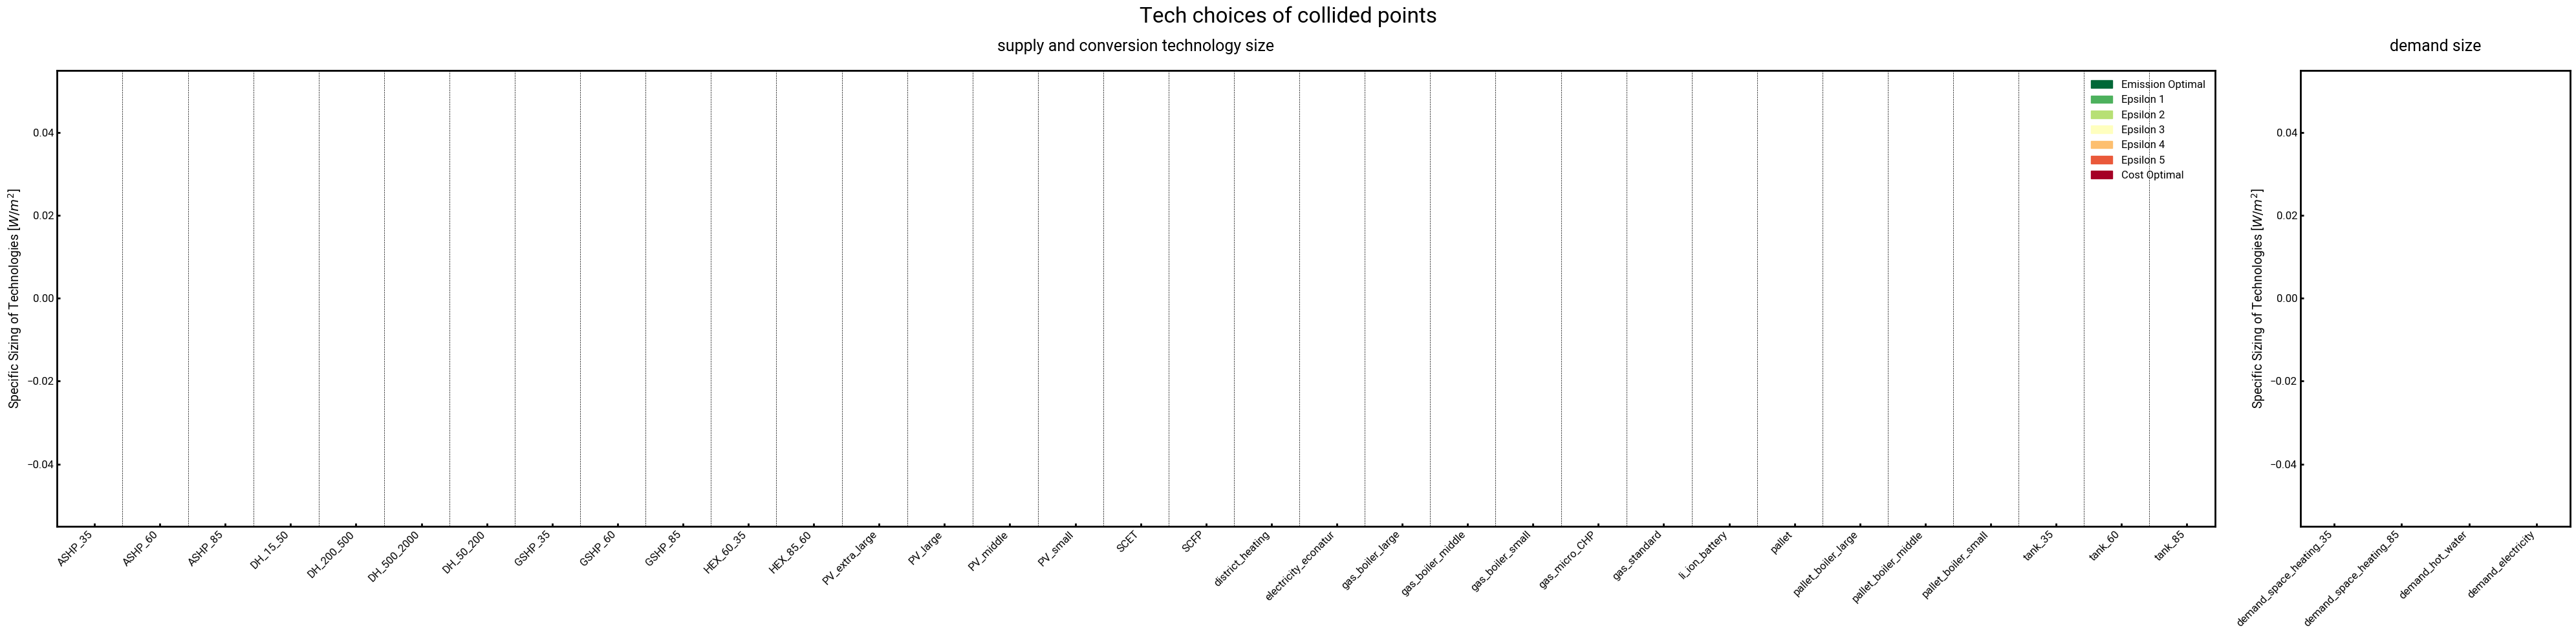

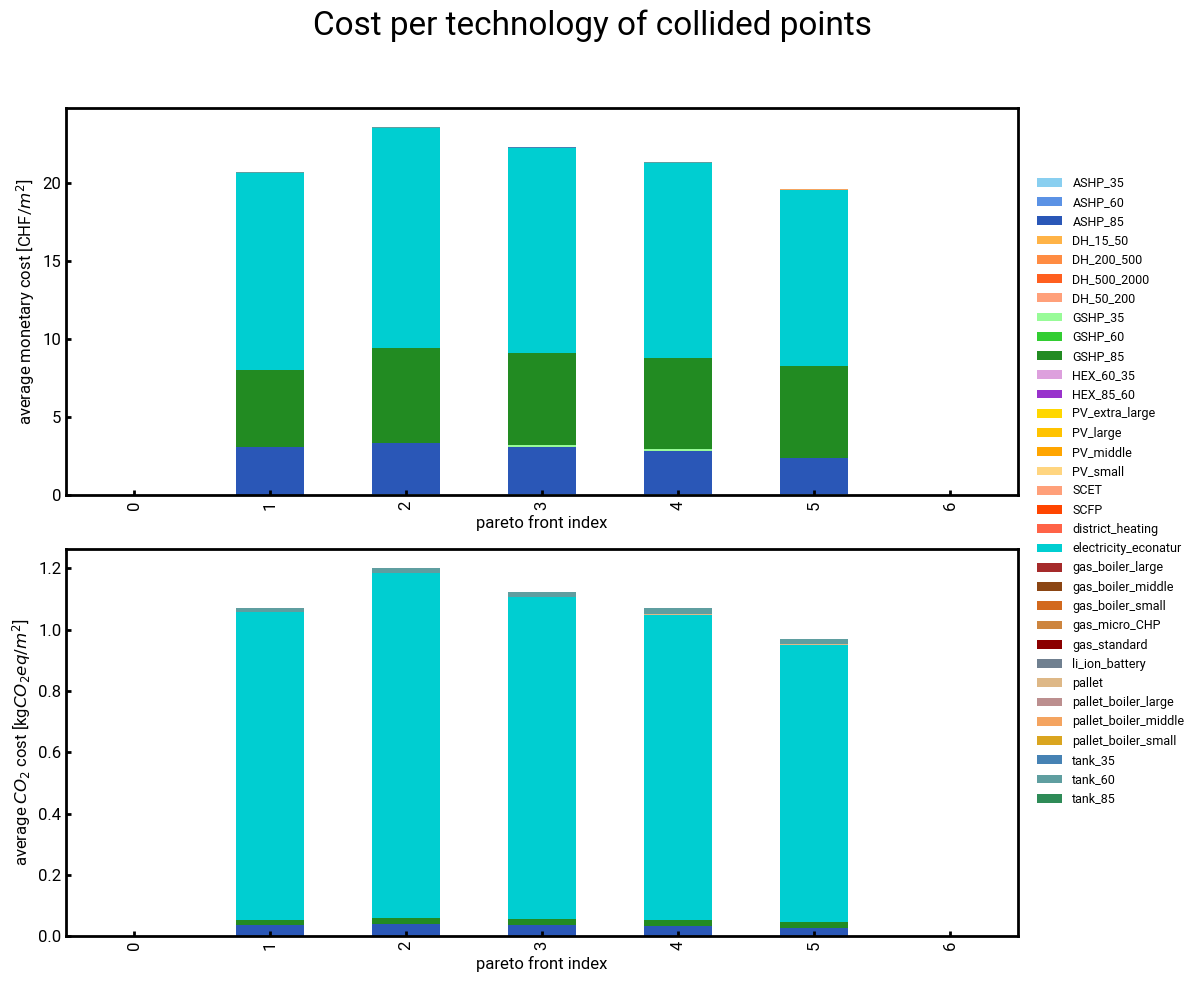

In [14]:
tech_size_boxplot(
    df_pareto_collided,
    ls_supply_name,
    demand_color_dict,
    title_left="supply and conversion technology size",
    title_right="demand size",
    title_fig="Tech choices of collided points",
    figsize=(40, 10),
    width_ratios=(8, 1),
)

tech_cost_stackedbar(
    df_cost_per_tech_collided,
    tech_colors,
    title="Cost per technology of collided points",
    figsize=(12, 10),
)

# Data Analysis

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    r2_score,
    mean_squared_error,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression
import shap

# if not with_oil:
#     zone_df = pd.read_csv(os.path.join(pareto_fronts_path, "zone_df.csv"), index_col=0)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## extending zone_df to contain tech activation information

In [4]:
# # extend the zone_df with the technology activation information
# from sensitivity_analysis.sa_model_variation import SensitivityAnalysis as SA

# ls_supply_activation_name = [f"{tech}_activation" for tech in ls_supply_name]
# zone_df[ls_supply_activation_name] = 0
# for building_name, row in zone_df.iterrows():
#     df_pareto = df_pareto_dict.get(building_name)
#     zone_df.loc[building_name, ls_supply_activation_name] = (
#         SA.count_specific_technology_activation(df_pareto, ls_supply_name).values
#     )

## explain clustering in fig2

In [5]:
data = zone_df.copy()
data.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
    ],
    inplace=True,
)
x_display = data.copy()
# x_display.drop(columns=["cluster"], inplace=True)
label_encoders = {}

for col in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

x = data.drop(columns=["cluster"])
y = data["cluster"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       201
         1.0       0.98      0.98      0.98       287
         2.0       0.50      0.12      0.20         8

    accuracy                           0.98       496
   macro avg       0.82      0.70      0.72       496
weighted avg       0.97      0.98      0.97       496



### using SHAP to explain the clustering

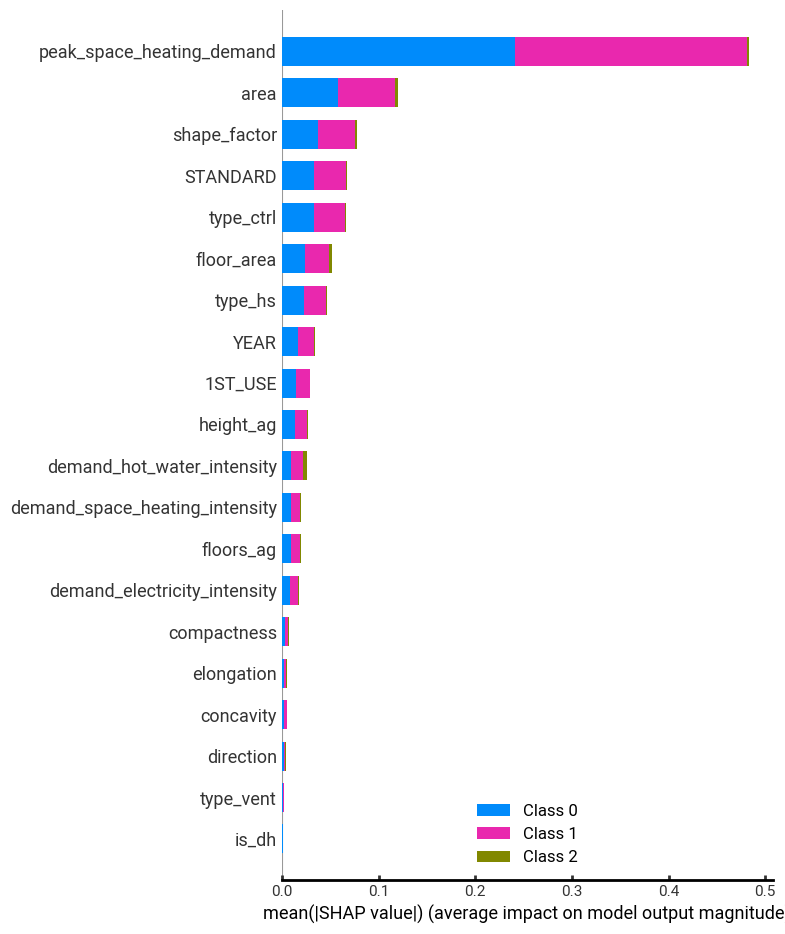

In [6]:
# use SHAP to explain the model
clf = RandomForestClassifier(random_state=42)
clf.fit(x, y)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x)

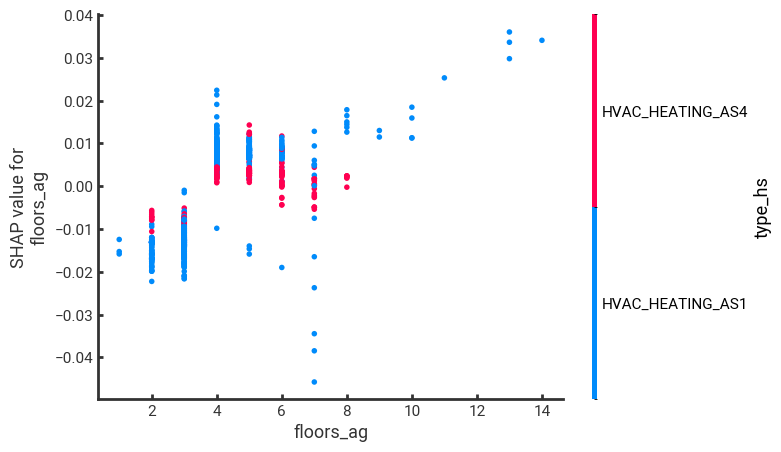

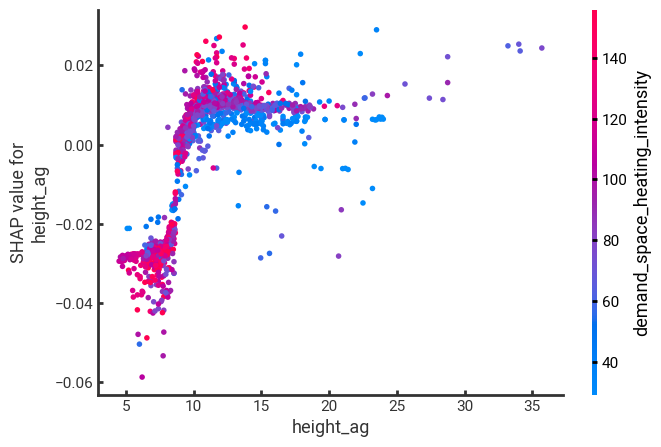

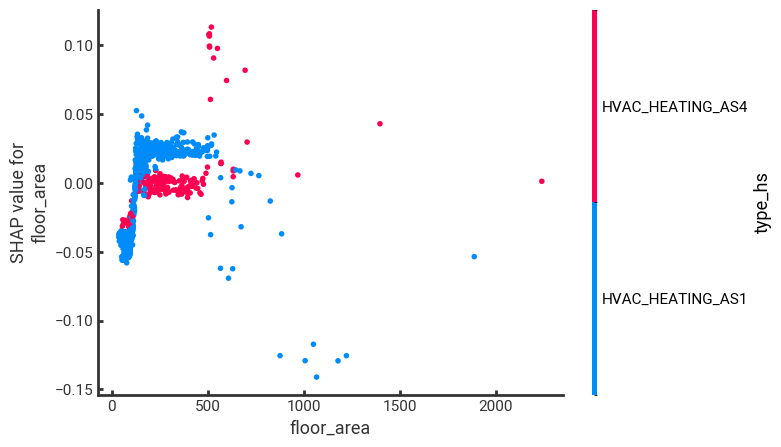

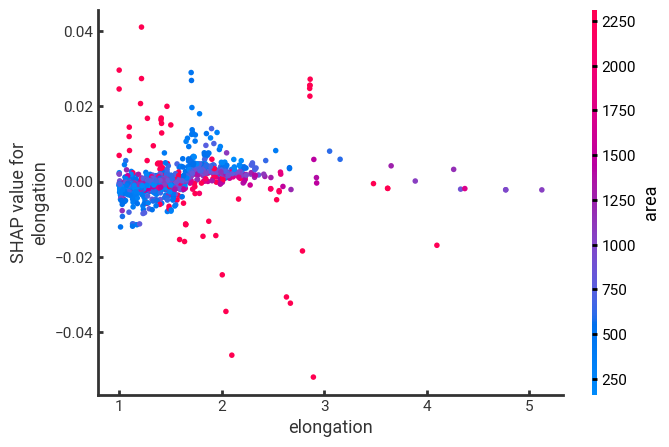

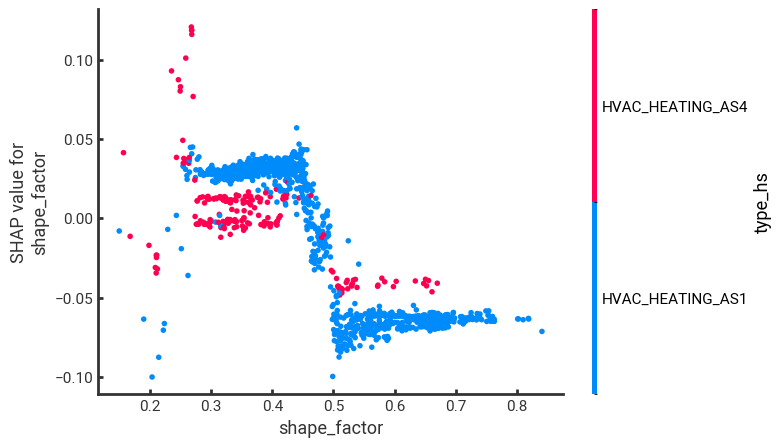

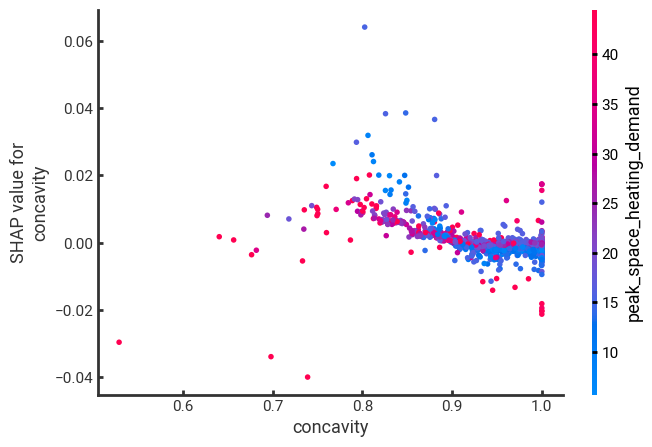

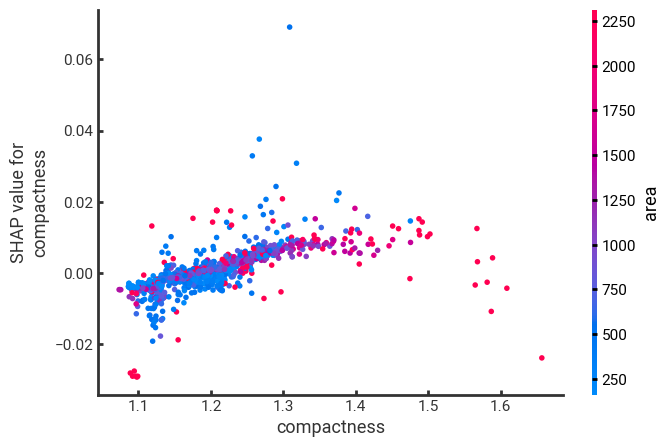

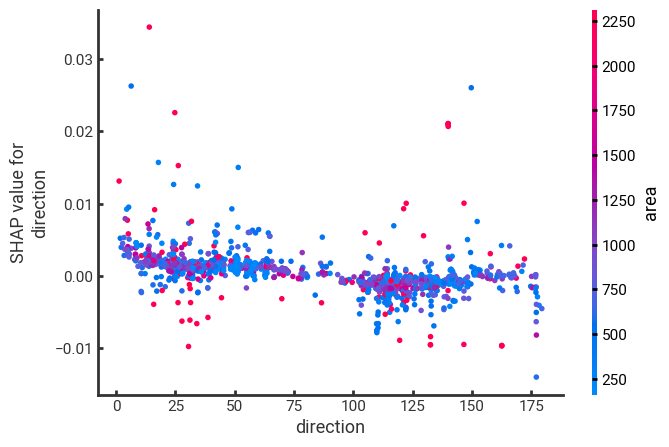

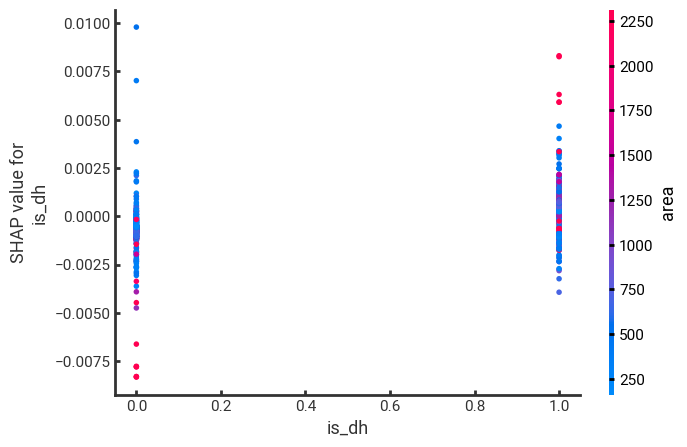

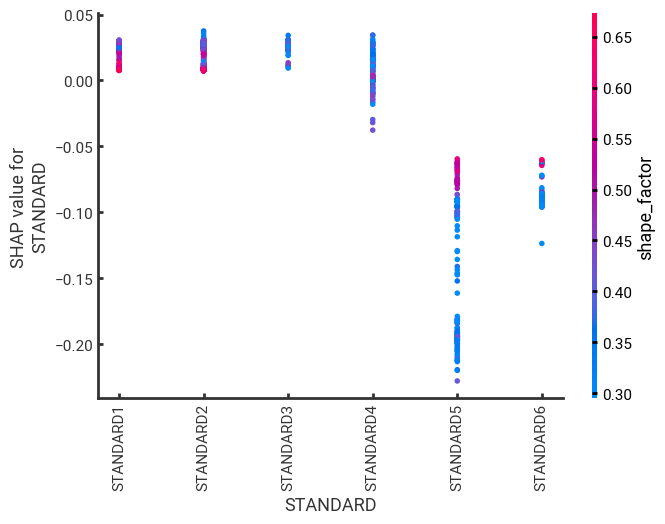

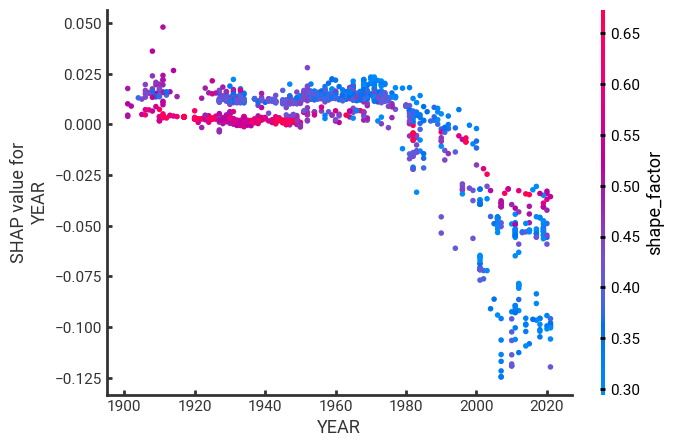

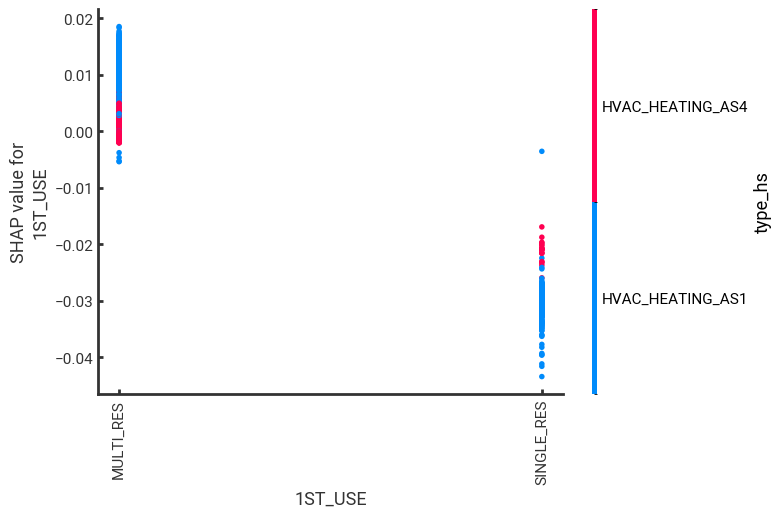

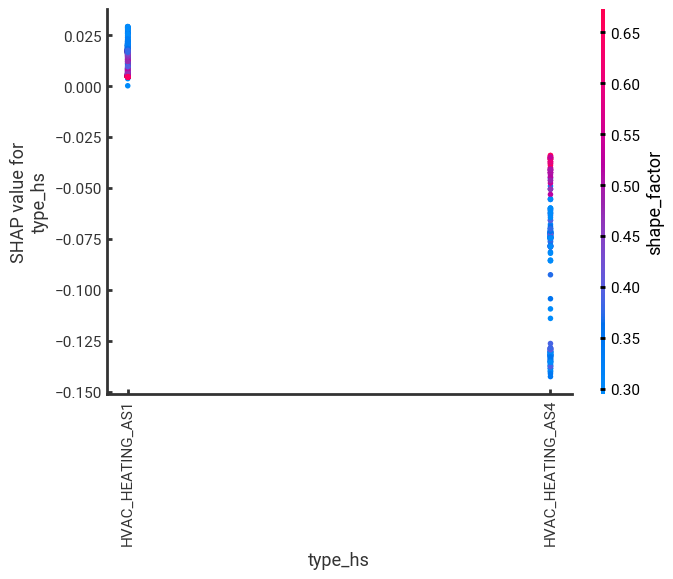

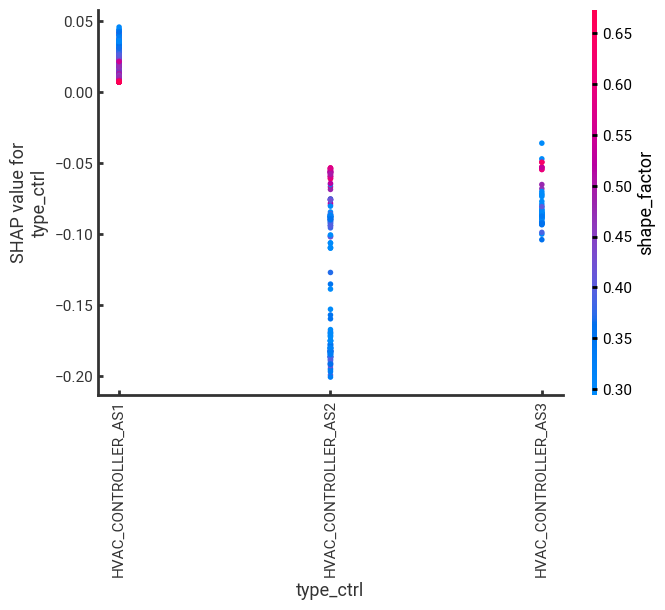

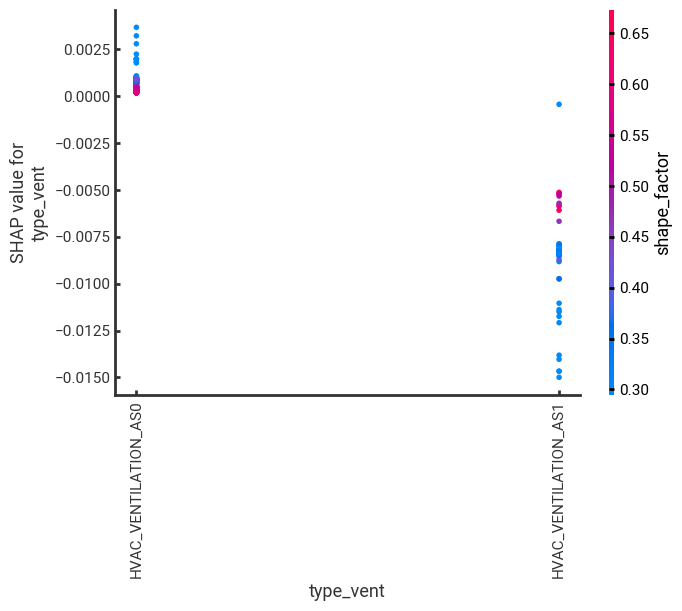

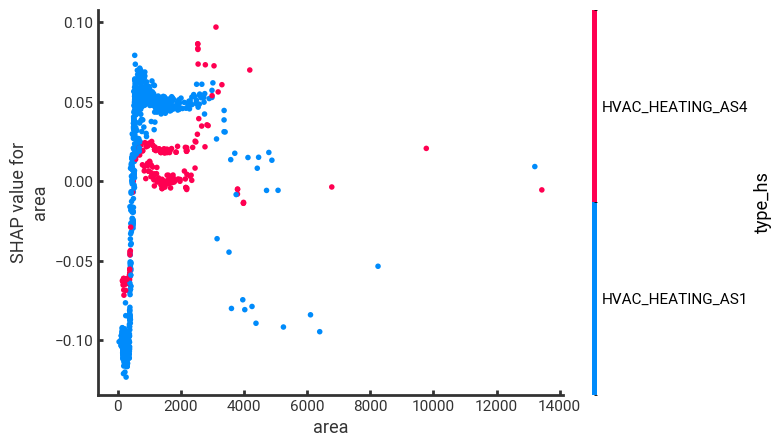

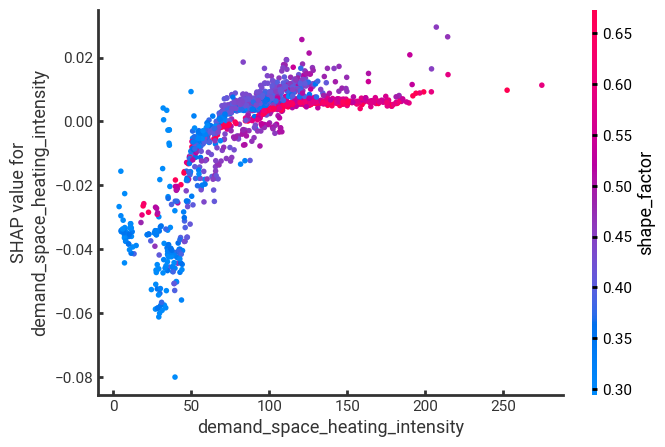

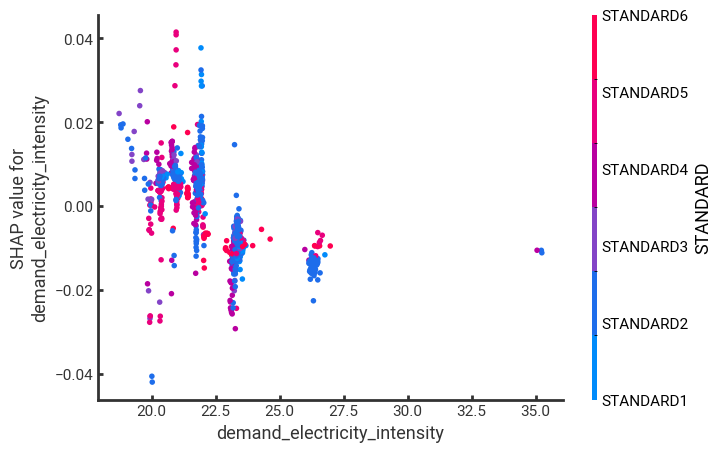

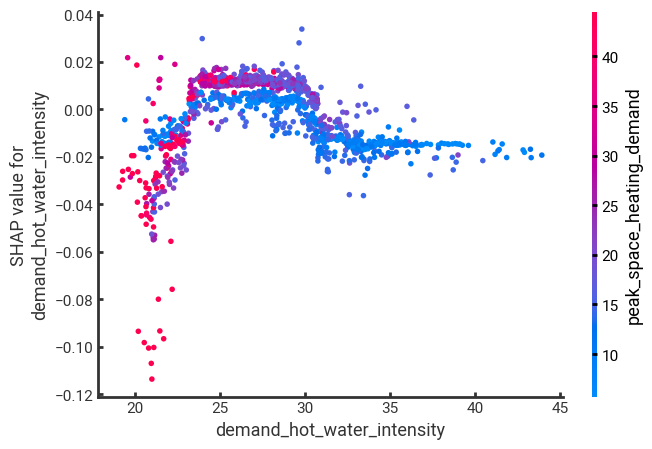

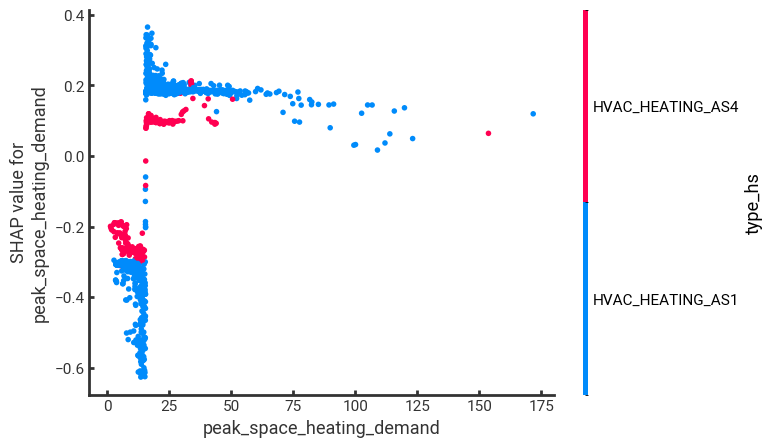

In [7]:
for col in x.columns:
    shap.dependence_plot(col, shap_values[1], x, display_features=zone_df)

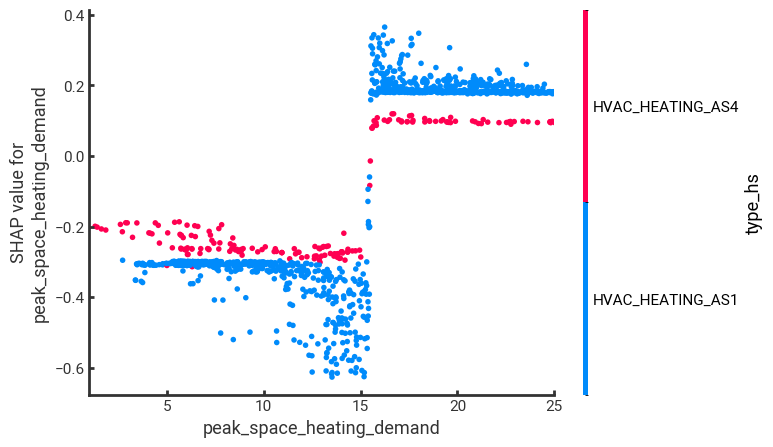

In [9]:
# shap.summary_plot(shap_values, x_test)
# shap.plots.beeswarm(shap_values)

shap.dependence_plot(
    "peak_space_heating_demand",
    shap_values[1],
    x,
    # interaction_index="1ST_USE",
    display_features=zone_df,
    show=False,
)
# shap.dependence_plot(
#     "1ST_USE",
#     shap_values[1],
#     x,
#     interaction_index="shape_factor",
#     display_features=zone_df,
# )
# limit x range from 0 to 3000
# plt.xlim(0, 1000)
# plt.show()
# for tech in data.columns:
#     shap.dependence_plot(tech, shap_values[1], x, show=False, display_features=x_display)
#     # set title for each plot
#     plt.title(tech)
# set x axis to be log scale
# plt.xscale("symlog")
plt.xlim(1, 25)
plt.show()

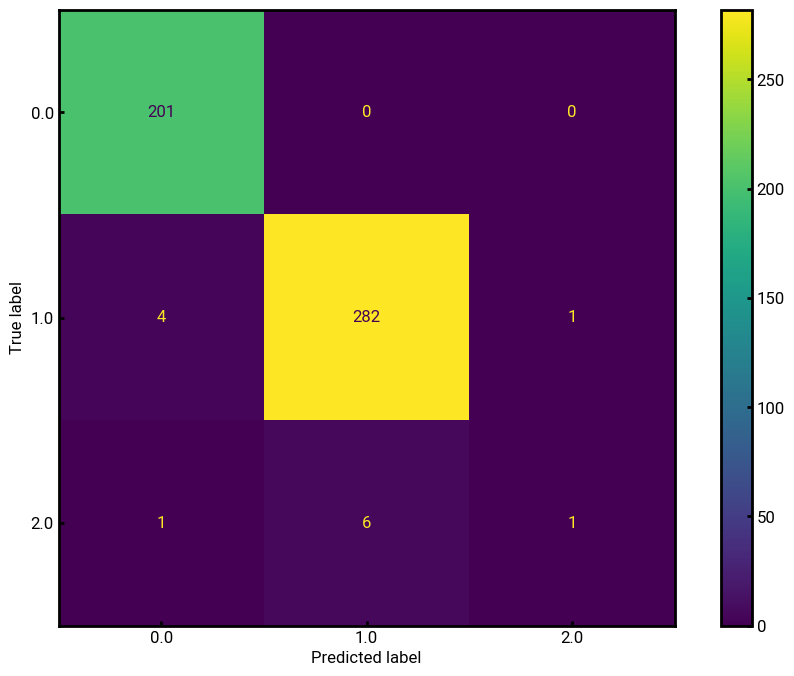

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
plt.show()

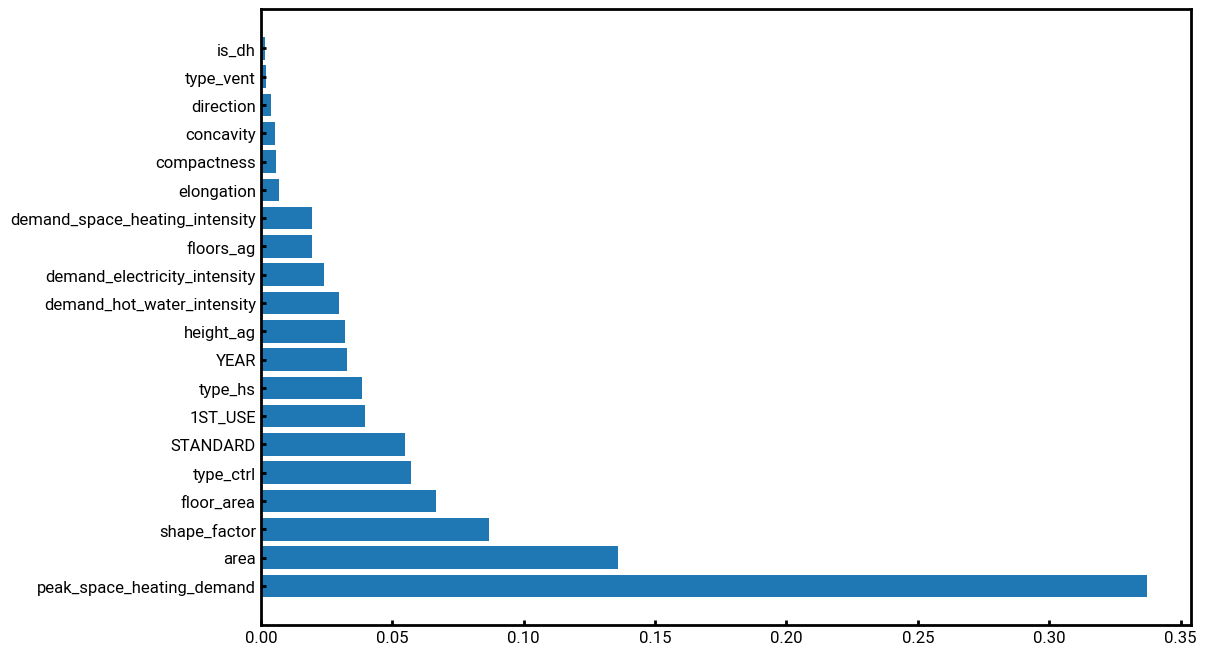

In [11]:
feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": clf.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

In [12]:
cv_scores = cross_val_score(clf, x, y, cv=5, scoring="accuracy")
print(f"Cv scores mean: {cv_scores.mean():.2f}, std: {cv_scores.std():.2f}")

Cv scores mean: 0.98, std: 0.01


In [22]:
shap_interaction_values_clustering = shap.TreeExplainer(clf).shap_interaction_values(x)

In [ ]:
shap.summary_plot(shap_interaction_values_clustering[1], x)

In [ ]:
for col in x.columns:
    shap.dependence_plot(
        ("peak_space_heating_demand", col),
        shap_interaction_values_clustering[1],
        x,
        display_features=zone_df,
    )

### explain distribution of second cluster in fig2

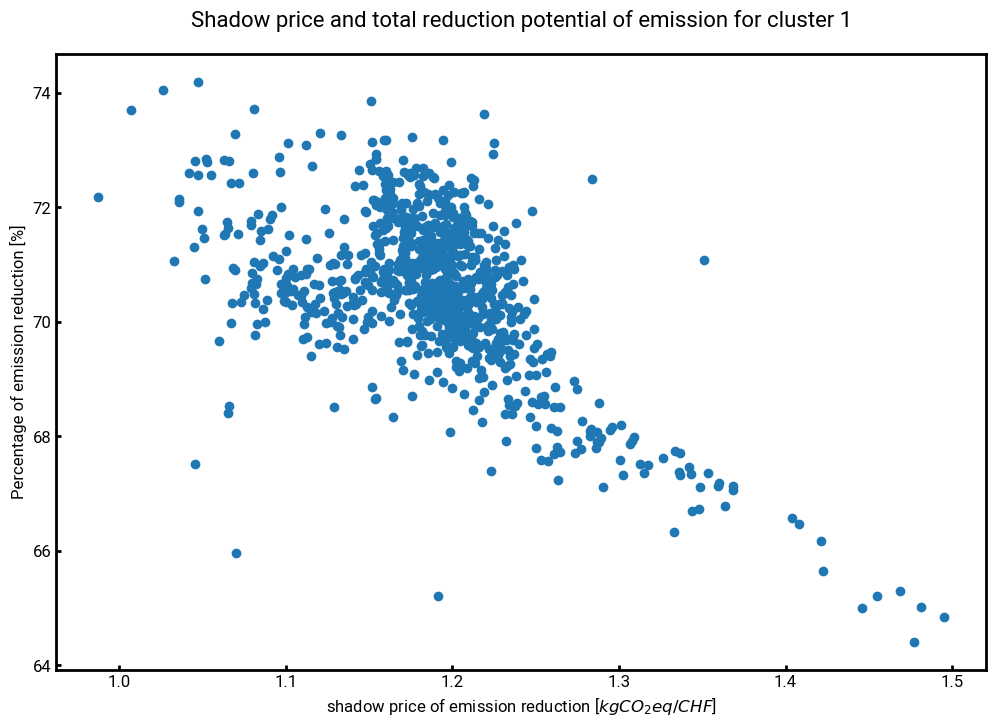

In [13]:
cluster_1 = zone_df[zone_df["cluster"] == 1]
# plot the relative emission reduction potential vs shadow price
fig, ax = plt.subplots()
ax.scatter(cluster_1["shadow_price"], cluster_1["emission_range_rel"] * 100)
ax.set_xlabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
ax.set_ylabel("Percentage of emission reduction [%]")
ax.set_title("Shadow price and total reduction potential of emission for cluster 1")
plt.show()

### random forest for second cluster in fig2

0.9424903509534983
Mean squared error: 0.00, R2 score: 0.94


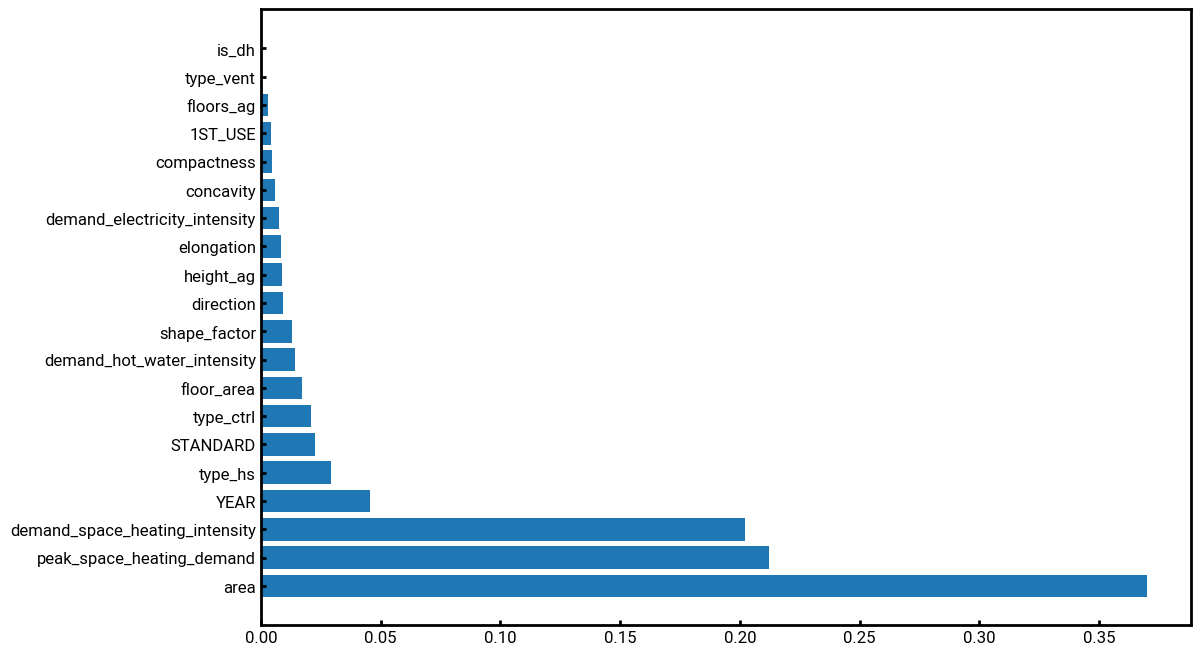

In [14]:
cluster_1_tree = cluster_1.copy()
for col in cluster_1_tree.select_dtypes(include="object").columns:
    cluster_1_tree[col] = label_encoders[col].transform(cluster_1_tree[col])


x = cluster_1_tree.drop(
    columns=[
        "shadow_price",
        "pf_curvature",
        "emission_range_abs",
        "cost_range",
        "emission_range_rel",
        "cluster",
    ]
)
y1 = cluster_1_tree["shadow_price"]
y2 = cluster_1_tree["emission_range_rel"]

x1_train, x1_test, y1_train, y1_test = train_test_split(
    x, y1, test_size=0.3, random_state=42
)
model = RandomForestRegressor(random_state=42)
model.fit(x1_train, y1_train)
y1_pred = model.predict(x1_test)
print(model.score(x1_test, y1_test))

mse = mean_squared_error(y1_test, y1_pred)
r2 = r2_score(y1_test, y1_pred)
print(f"Mean squared error: {mse:.2f}, R2 score: {r2:.2f}")

feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

In [15]:
model_full = RandomForestRegressor(random_state=42)
model_full.fit(x, y1)
explainer = shap.TreeExplainer(model_full)
shap_values = explainer.shap_values(x)

Text(0.5, 1.03, 'SHAP summary plot for cluster 1 on emission reduction potential')

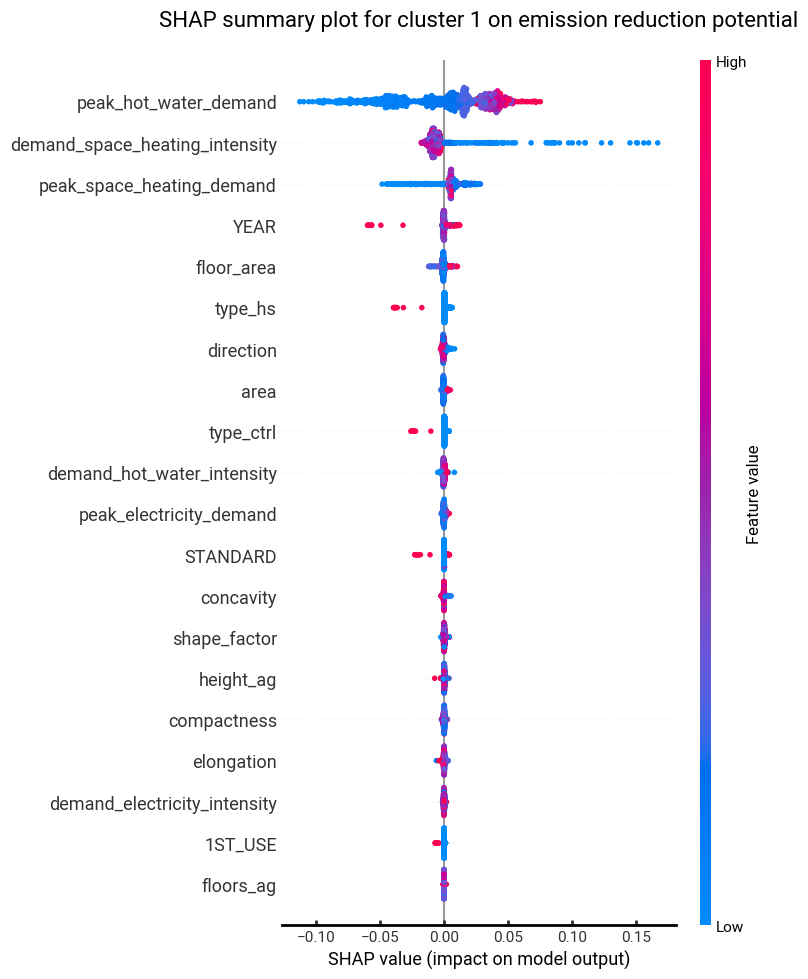

In [29]:
shap.summary_plot(shap_values, x, show=False)
# set title
plt.title("SHAP summary plot for cluster 1 on emission reduction potential")

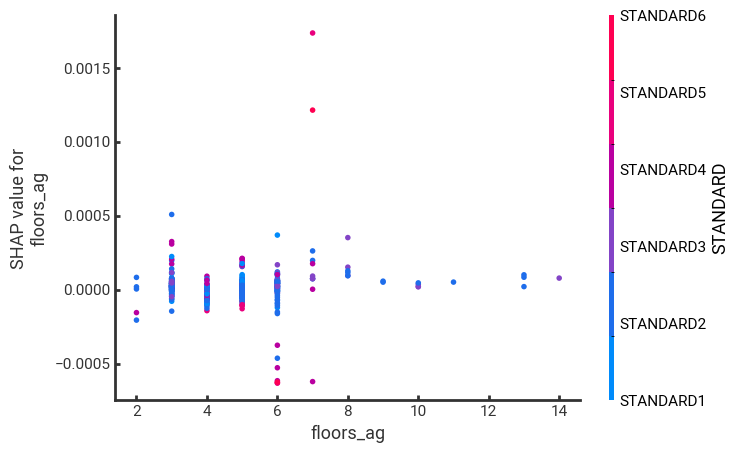

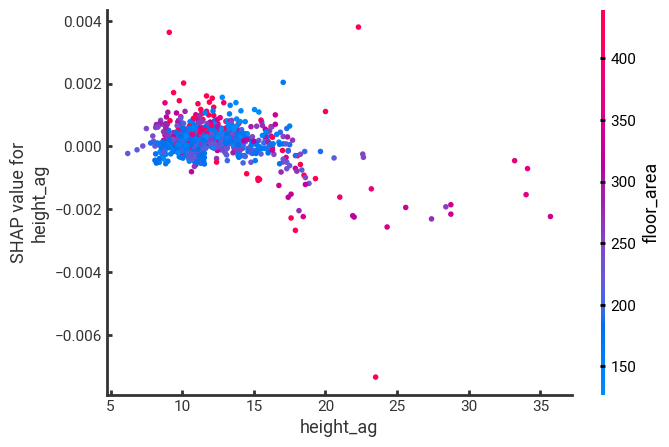

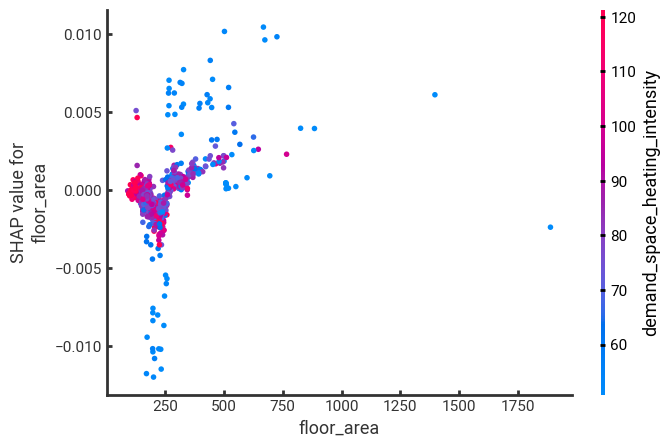

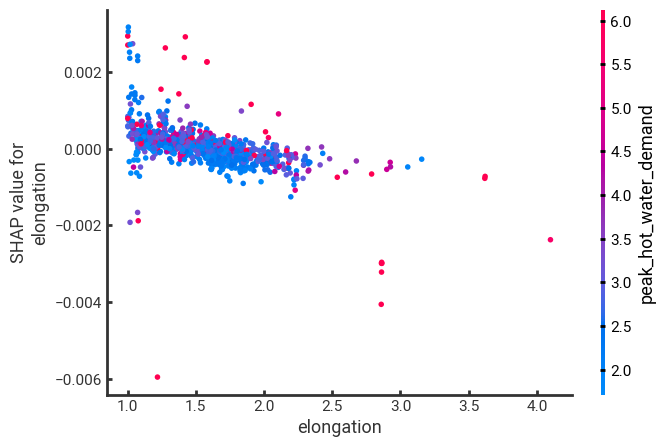

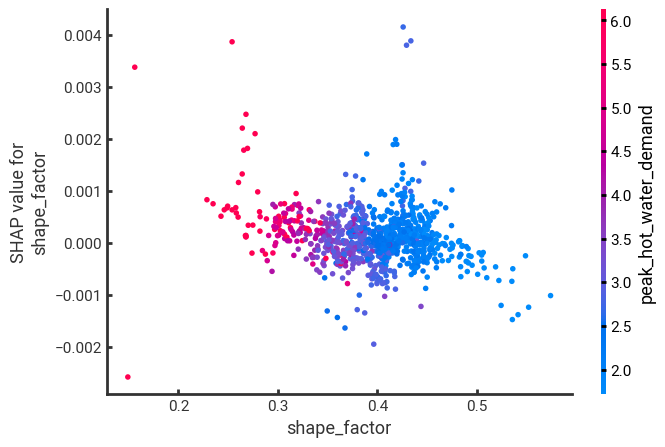

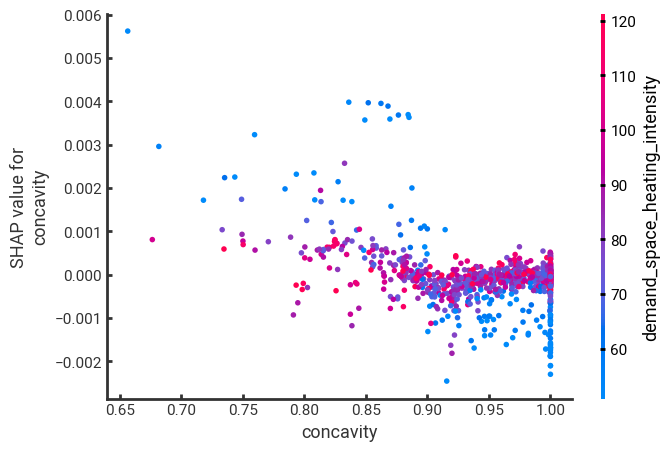

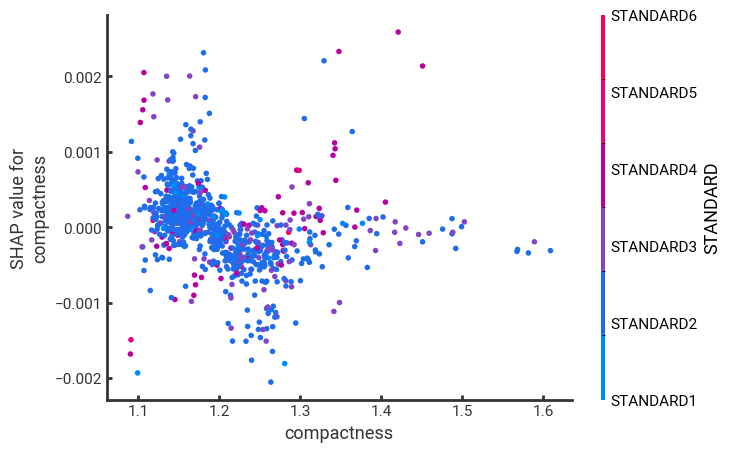

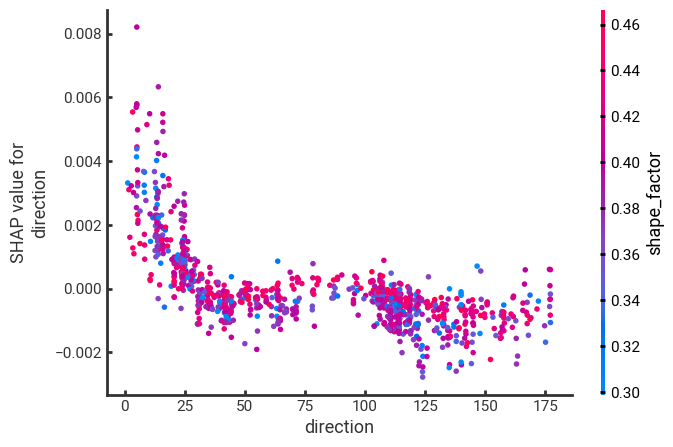

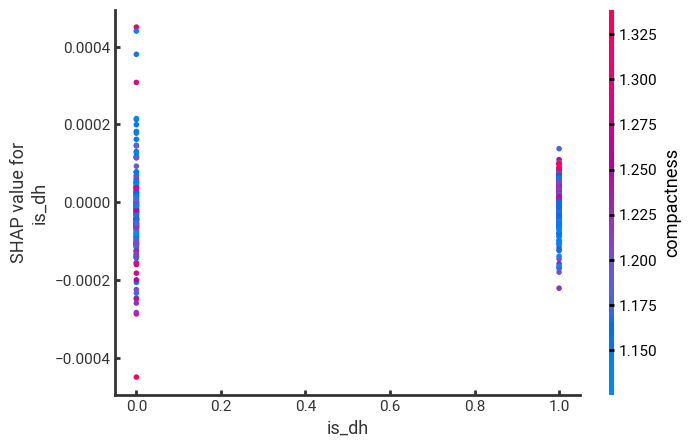

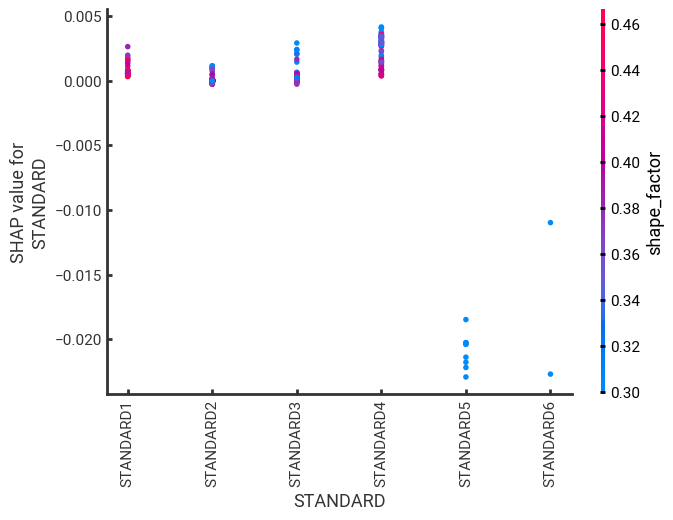

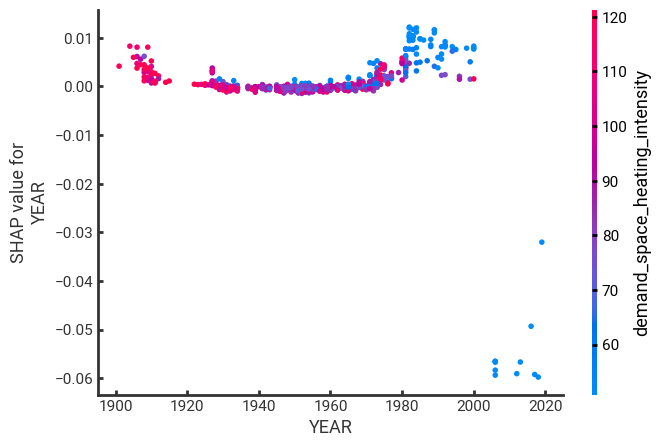

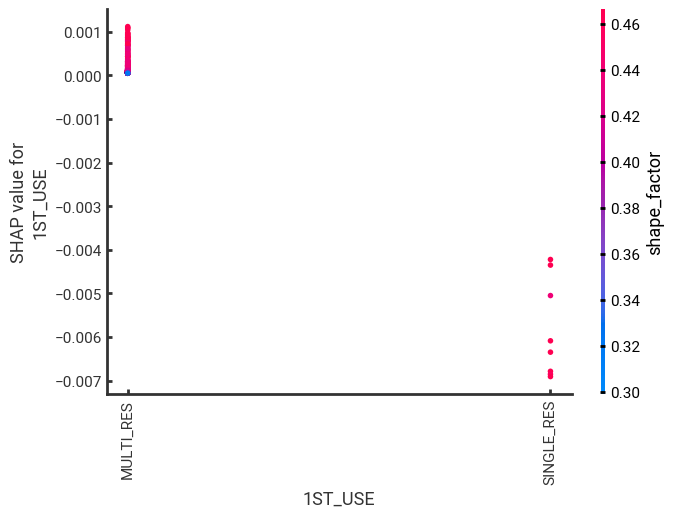

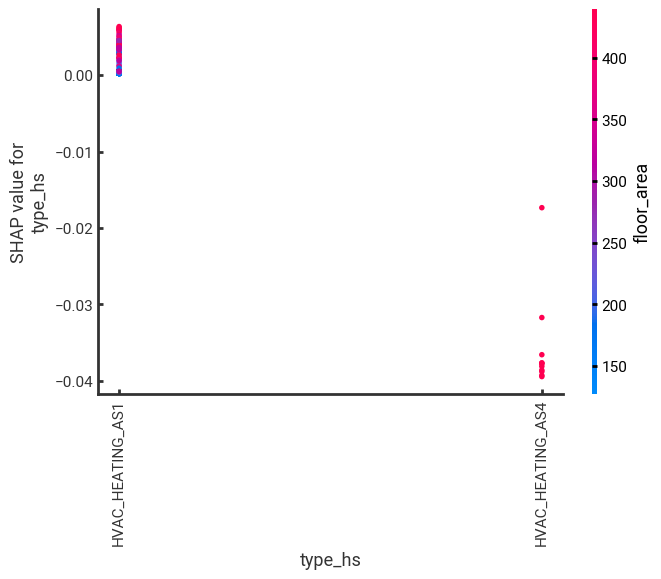

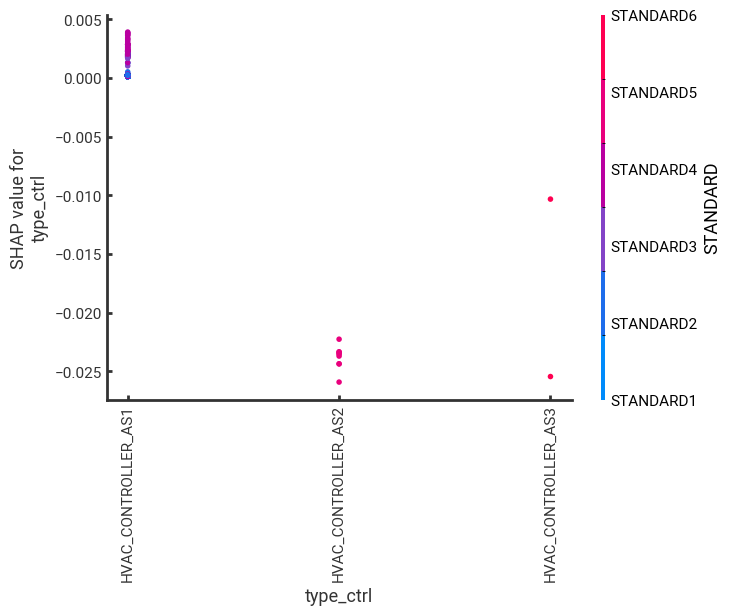

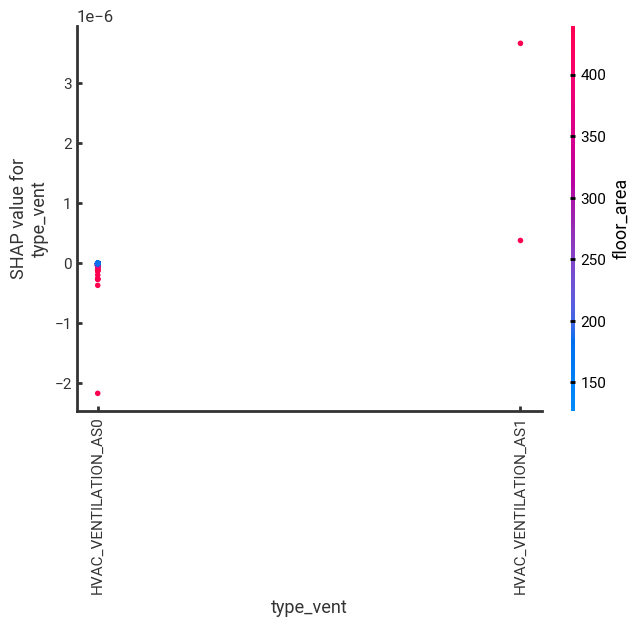

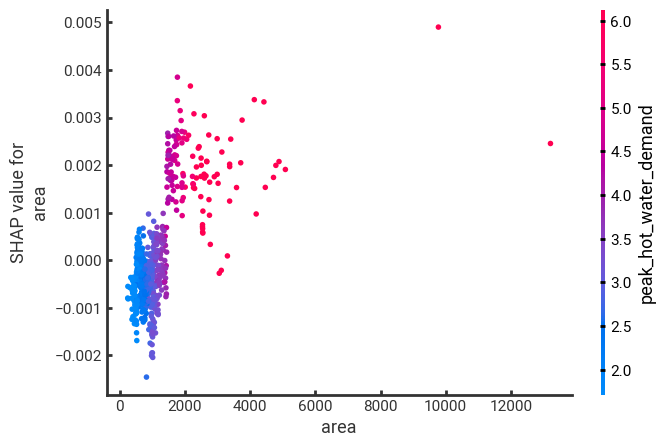

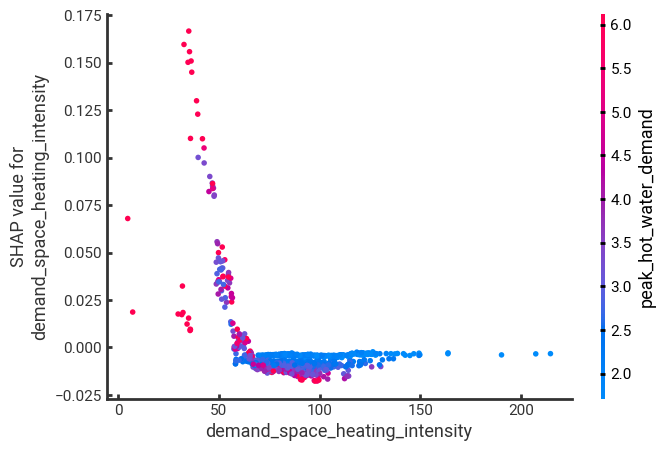

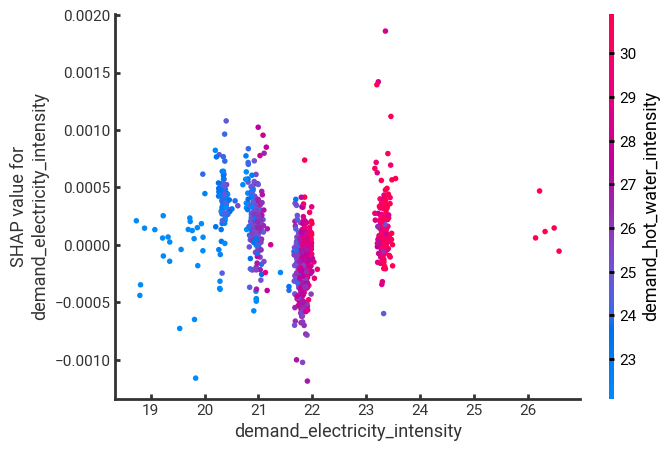

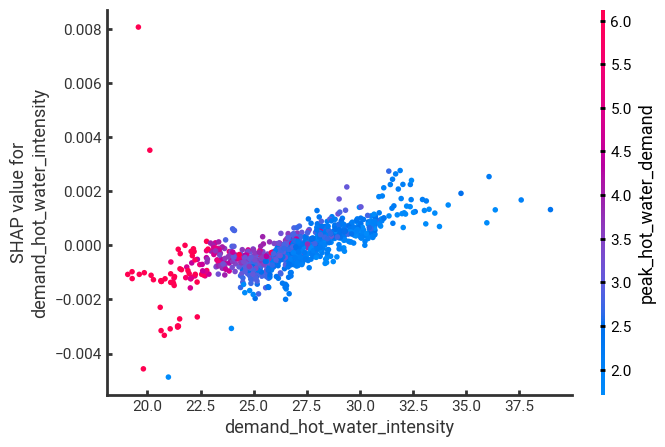

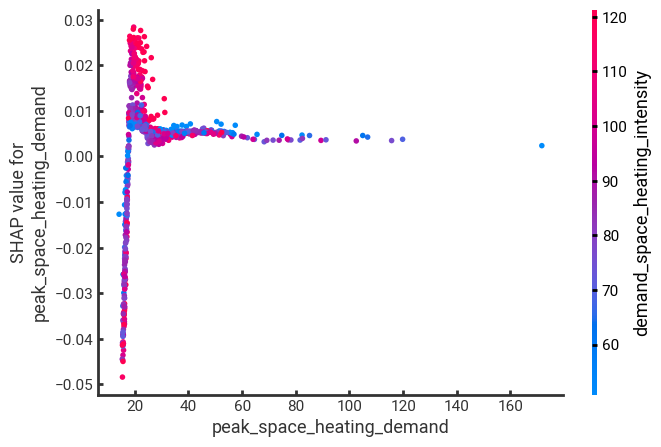

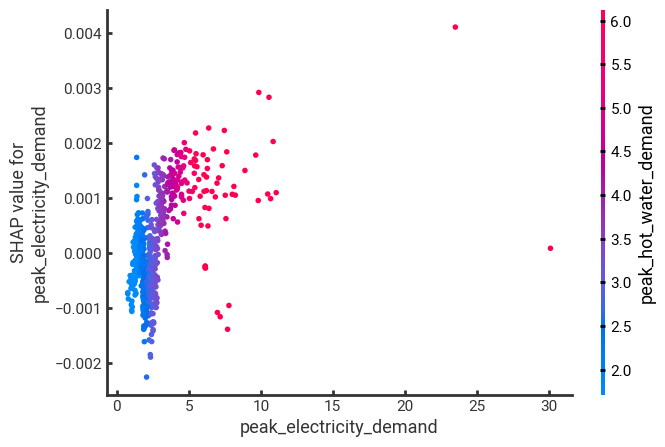

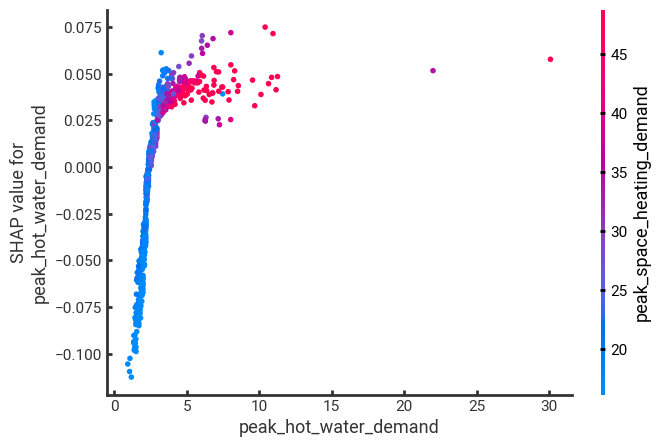

In [30]:
for tech in x.columns:
    shap.dependence_plot(tech, shap_values, x, display_features=cluster_1)

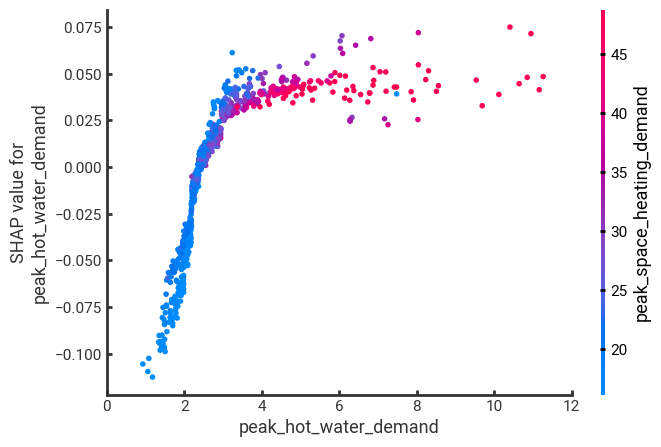

In [35]:
shap.dependence_plot(
    "peak_hot_water_demand",
    shap_values,
    x,
    display_features=cluster_1,
    show=False,
    # interaction_index="demand_hot_water_intensity",
)
# set x range from 0 to 3000
plt.xlim(0, 12)
plt.show()

In [36]:
shap_interaction_values = shap.TreeExplainer(model_full).shap_interaction_values(x)

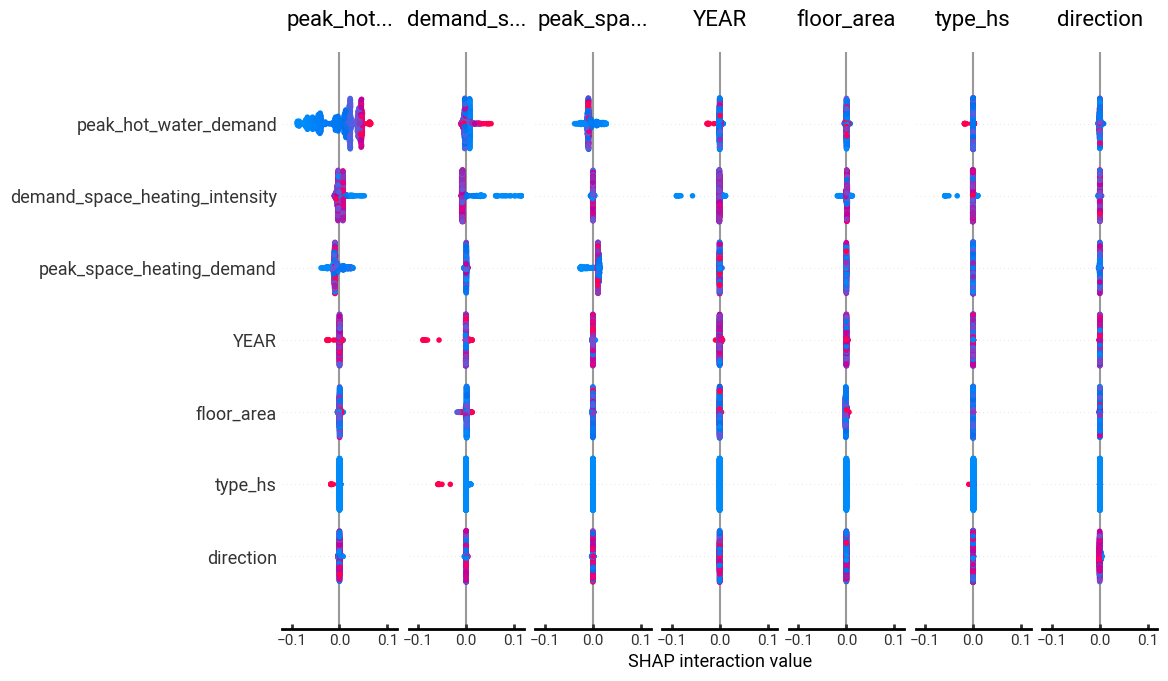

In [37]:
shap.summary_plot(shap_interaction_values, x)

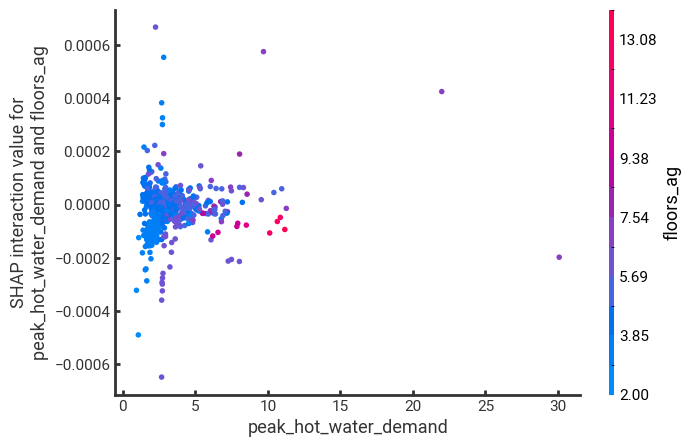

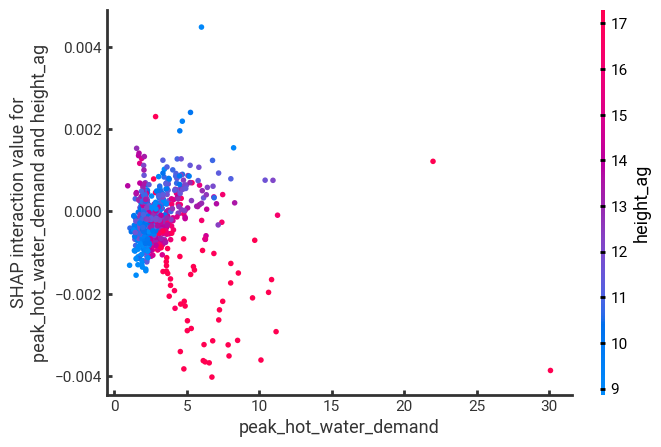

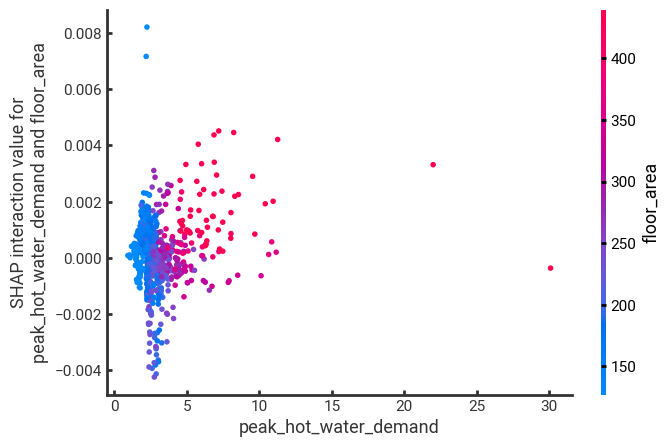

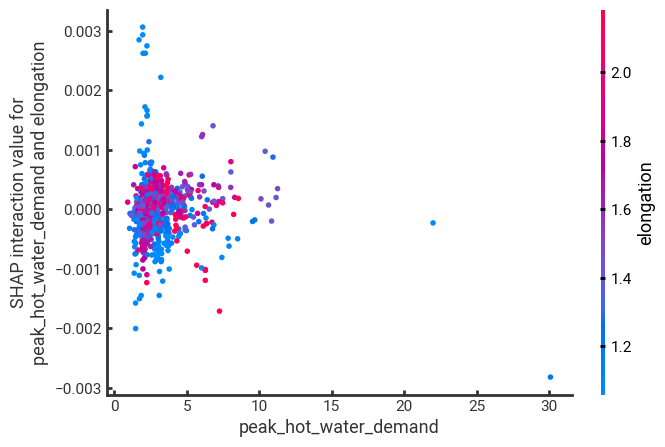

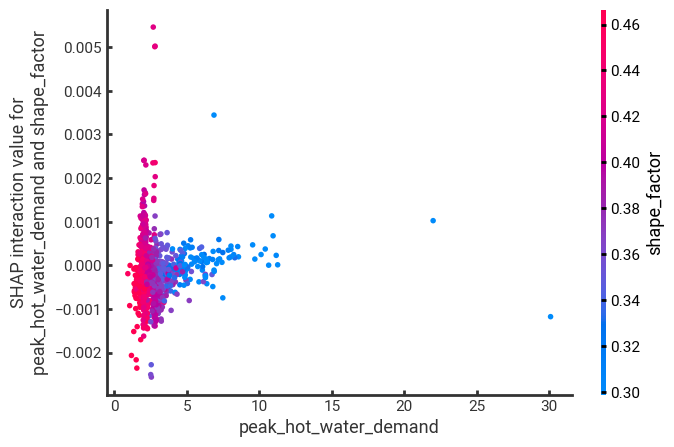

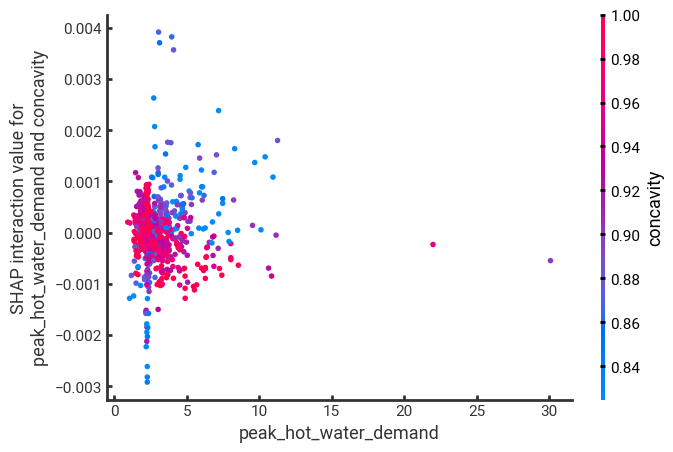

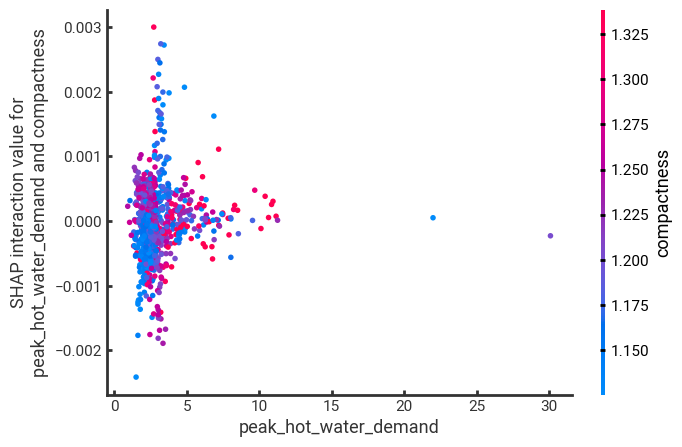

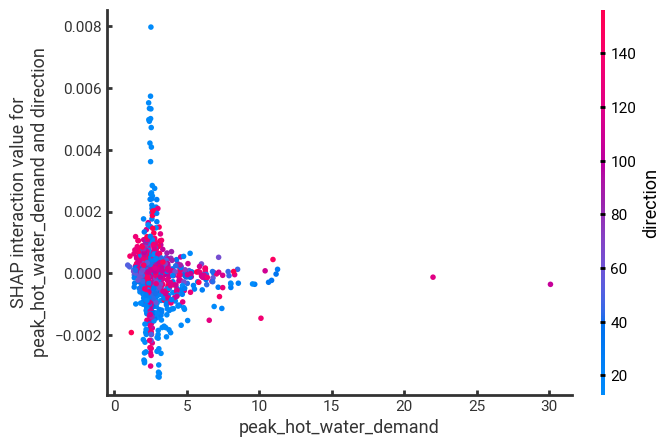

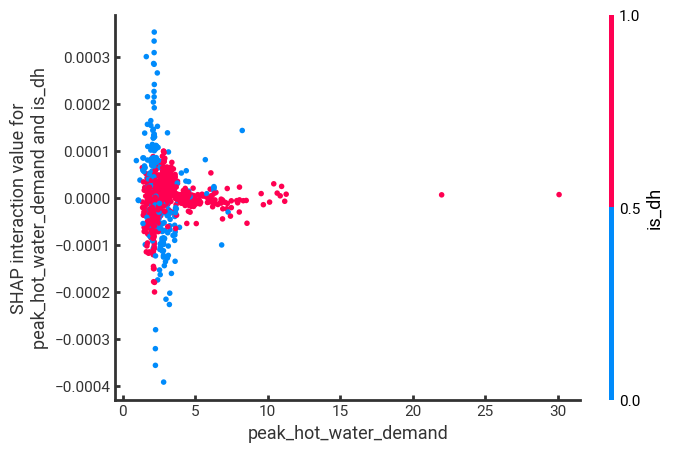

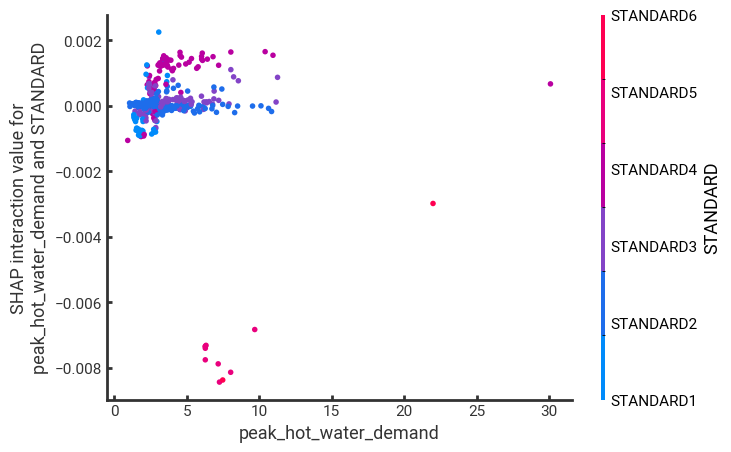

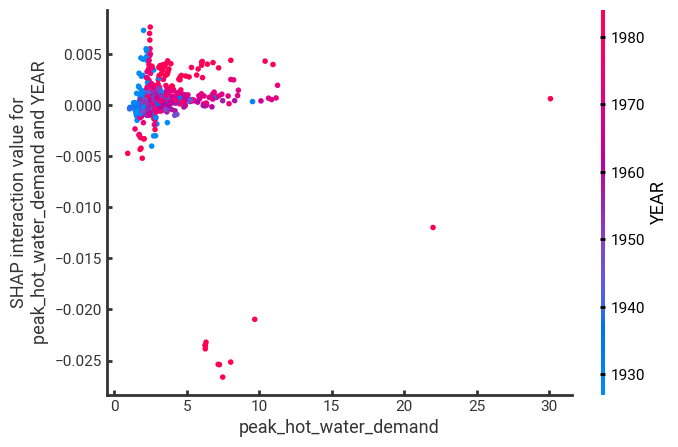

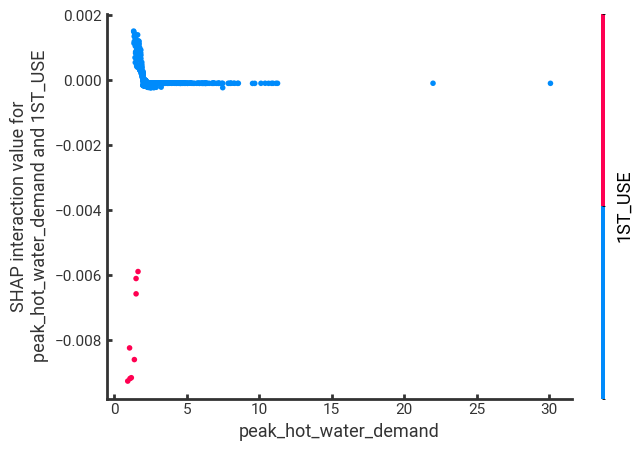

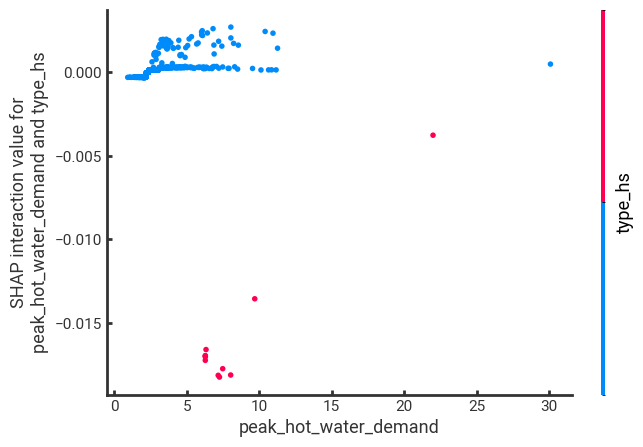

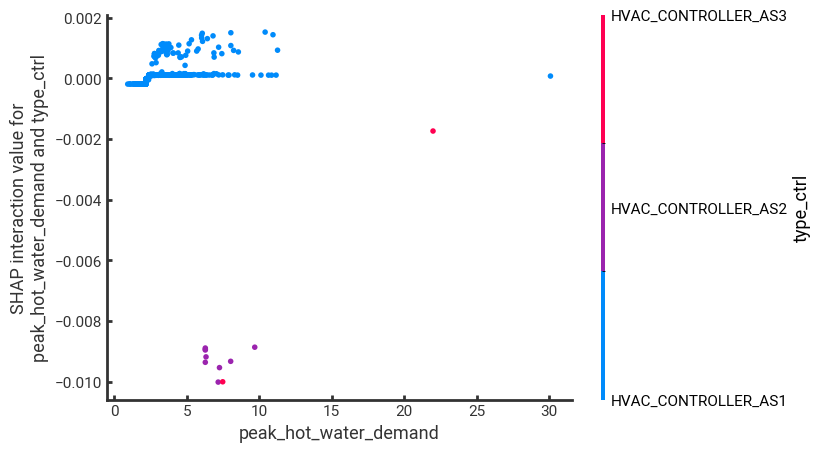

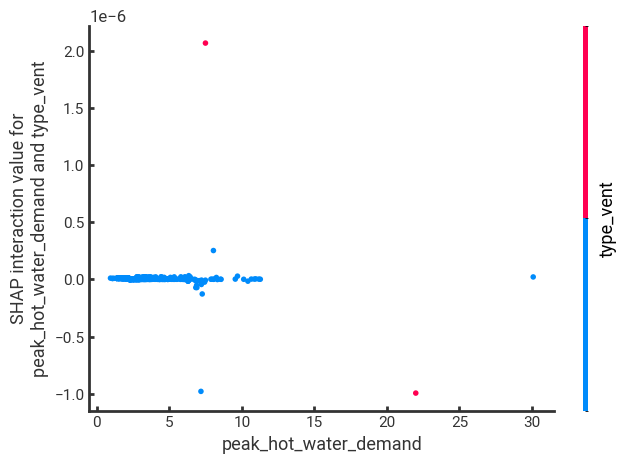

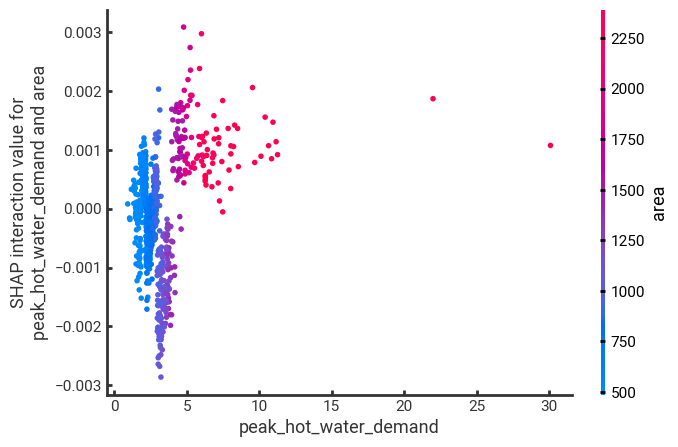

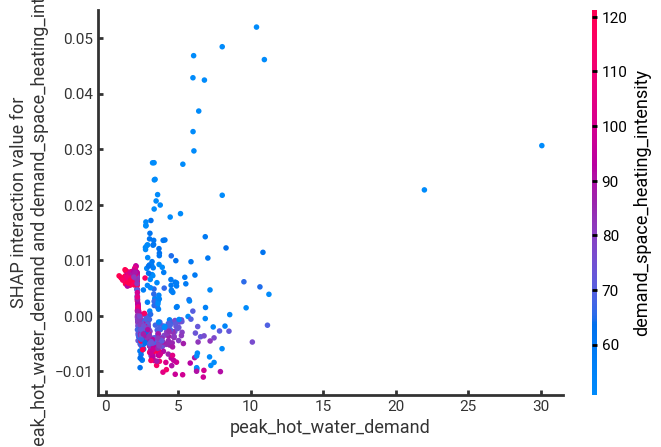

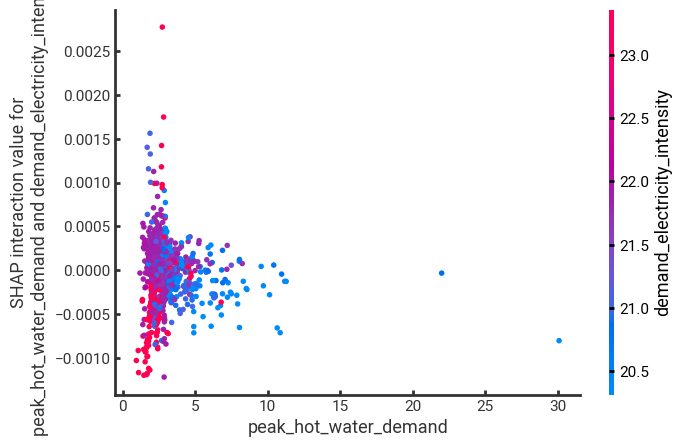

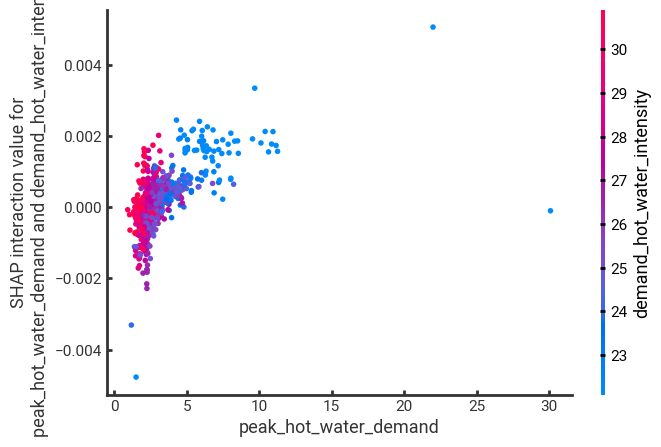

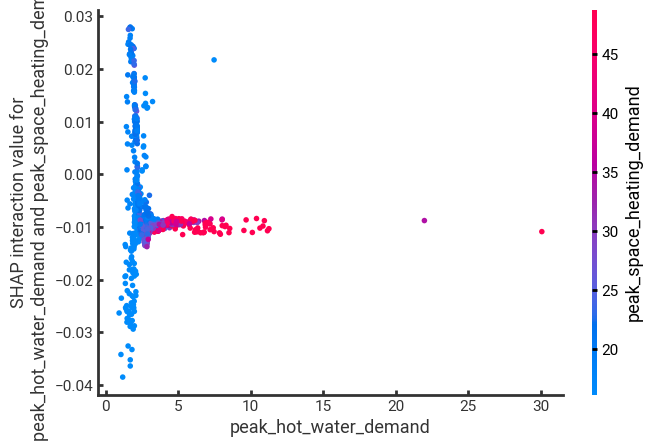

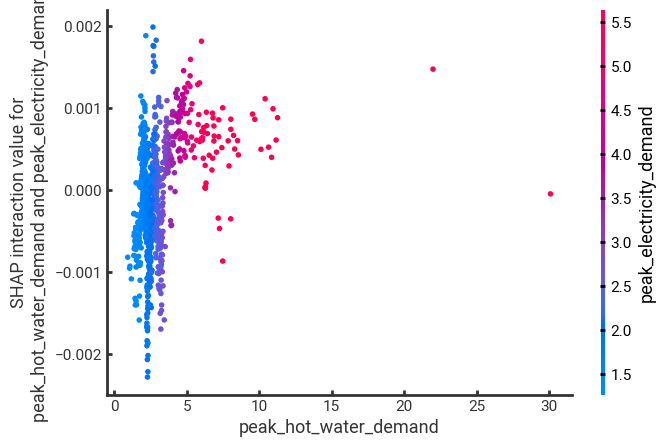

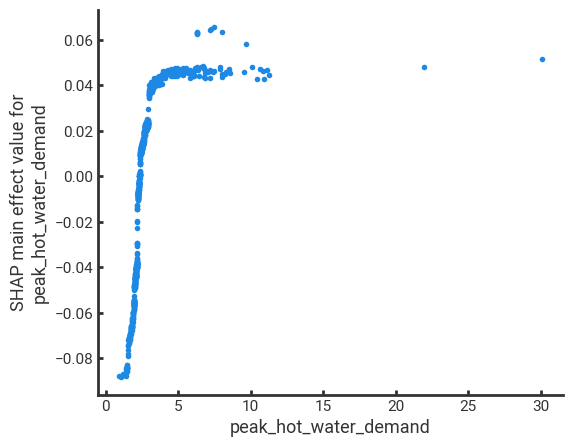

In [39]:
for col in x.columns:
    shap.dependence_plot(
        ("peak_hot_water_demand", col),
        shap_interaction_values,
        x,
        display_features=cluster_1,
    )

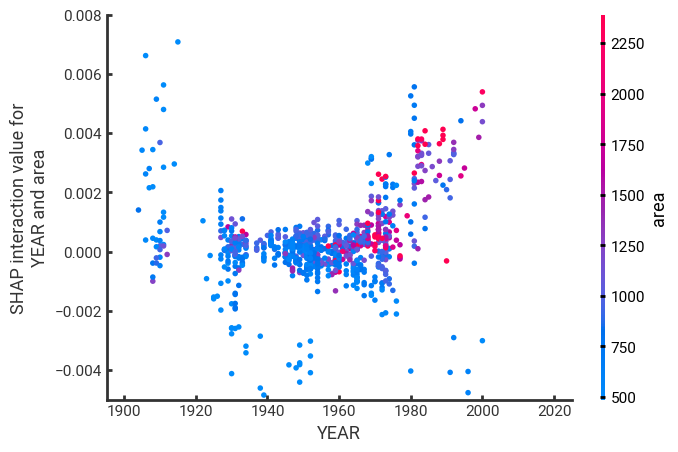

In [49]:
shap.dependence_plot(
    ("YEAR", "area"),
    shap_interaction_values,
    x,
    display_features=cluster_1,
    show=False,
)
# plt.xlim(0, 3000)
plt.ylim(-0.005, 0.008)
plt.show()

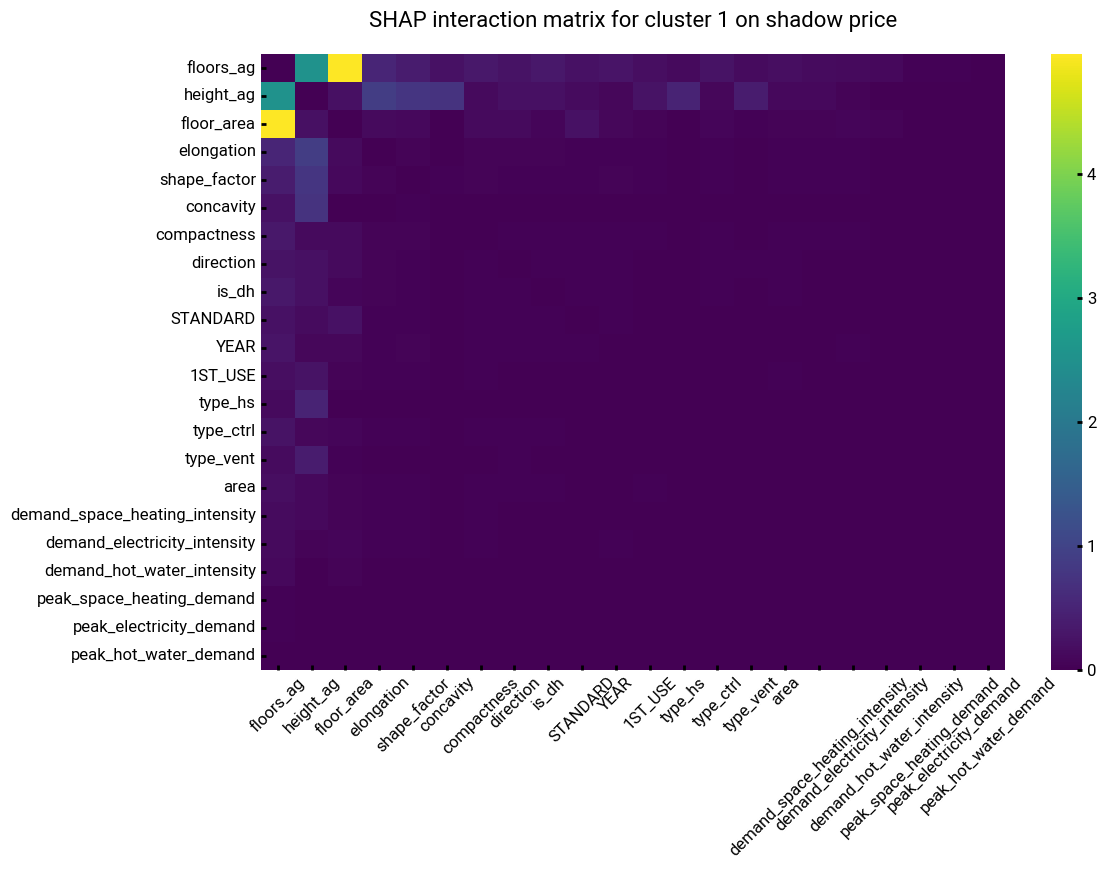

In [38]:
temp = np.abs(shap_interaction_values).sum(0)
for i in range(temp.shape[0]):
    temp[i, i] = 0

inds = np.argsort(-temp.sum(0))[:50]
temp2 = temp[inds, :][:, inds]
# use seaborn to plot a heatmap of the interaction matrix
fig, ax = plt.subplots()
sns.heatmap(temp2, xticklabels=x.columns, yticklabels=x.columns, cmap="viridis", ax=ax)
# set title
plt.title("SHAP interaction matrix for cluster 1 on shadow price")
# rotate x labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


Text(0.5, 1.03, 'Correlation matrix for cluster 1')

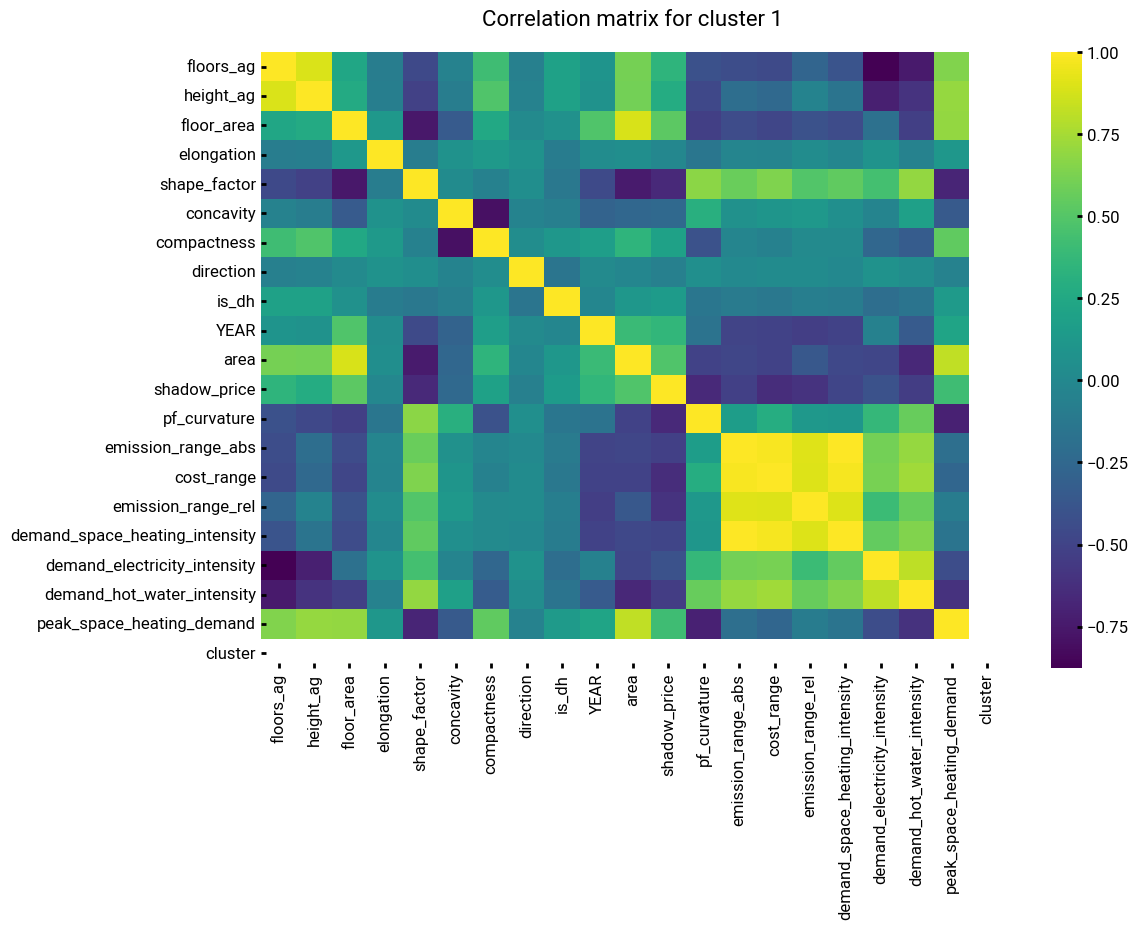

In [16]:
# plot the correlation matrix for the cluster 1
fig, ax = plt.subplots()
sns.heatmap(cluster_1.corr(), cmap="viridis", ax=ax)
plt.title("Correlation matrix for cluster 1")

0.9846554250468867
Mean squared error: 0.00, R2 score: 0.98


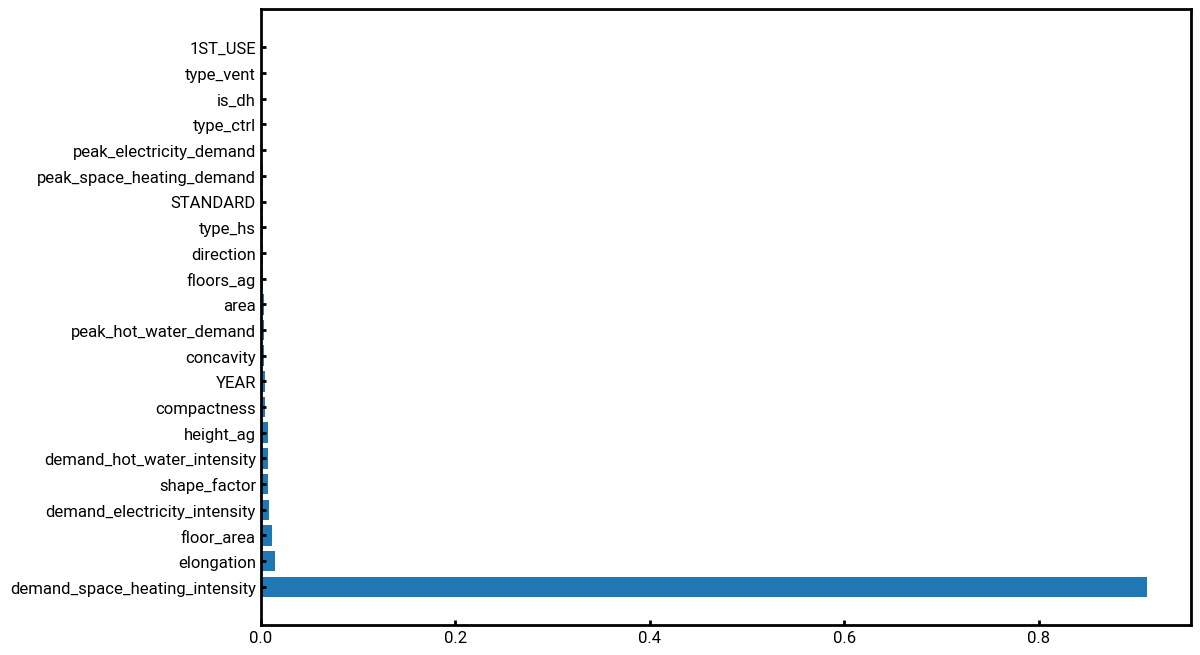

In [40]:
x2_train, x2_test, y2_train, y2_test = train_test_split(
    x, y2, test_size=0.3, random_state=42
)
model = RandomForestRegressor(random_state=42)
model.fit(x2_train, y2_train)
y2_pred = model.predict(x2_test)
print(model.score(x2_test, y2_test))

mse = mean_squared_error(y2_test, y2_pred)
r2 = r2_score(y2_test, y2_pred)
print(f"Mean squared error: {mse:.2f}, R2 score: {r2:.2f}")

feature_importance = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

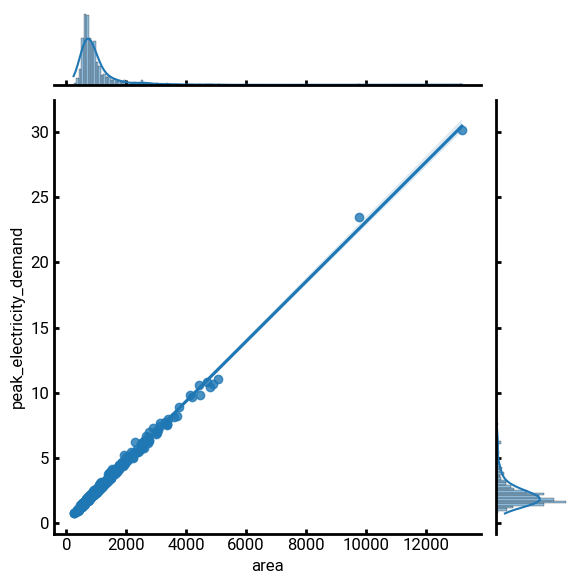

In [58]:
# pairplot all the features against shadow price and relative emission reduction potential
# sns.jointplot(x="area", y="peak_hot_water_demand", data=cluster_1)
# add linear regression line and label r2 score
sns.jointplot(x="area", y="peak_electricity_demand", data=cluster_1, kind="reg")

Ignoring `ax`; jointplot is a figure-level function.


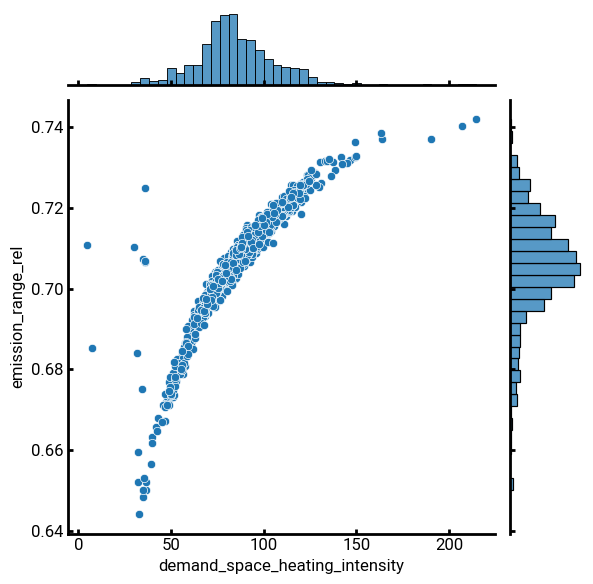

In [ ]:
sns.jointplot(
    x="demand_space_heating_intensity", y="emission_range_rel", data=cluster_1, ax=ax
)

# plt.show()

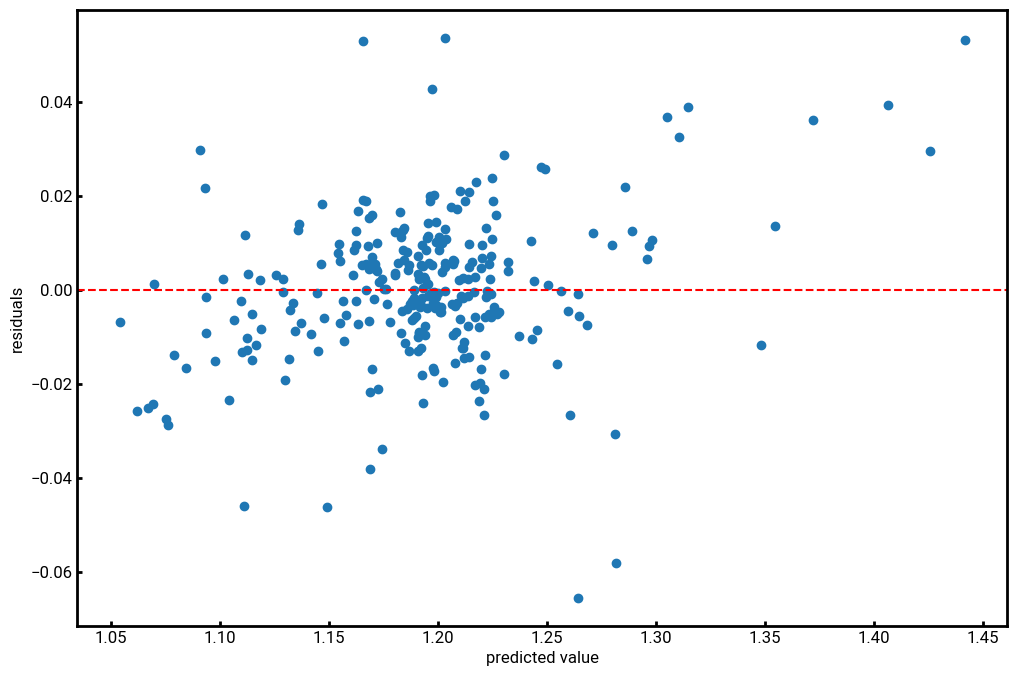

In [52]:
y1_residuals = y1_test - y1_pred
fig, ax = plt.subplots()
ax.scatter(y1_pred, y1_residuals)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("predicted value")
ax.set_ylabel("residuals")
plt.show()

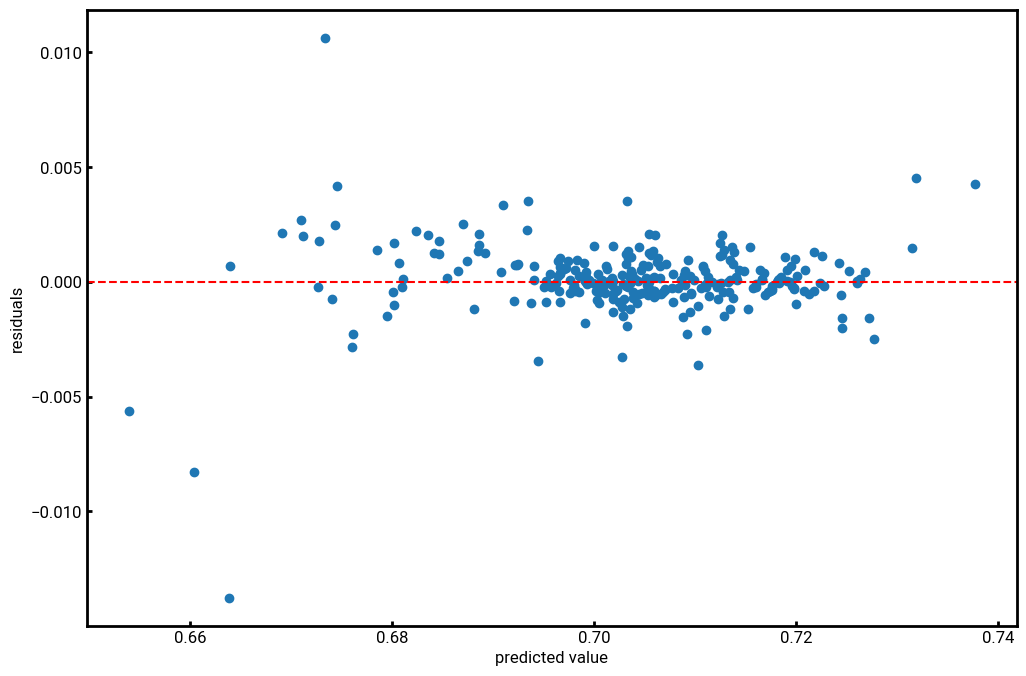

In [53]:
y2_residuals = y2_test - y2_pred
fig, ax = plt.subplots()
ax.scatter(y2_pred, y2_residuals)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("predicted value")
ax.set_ylabel("residuals")
plt.show()

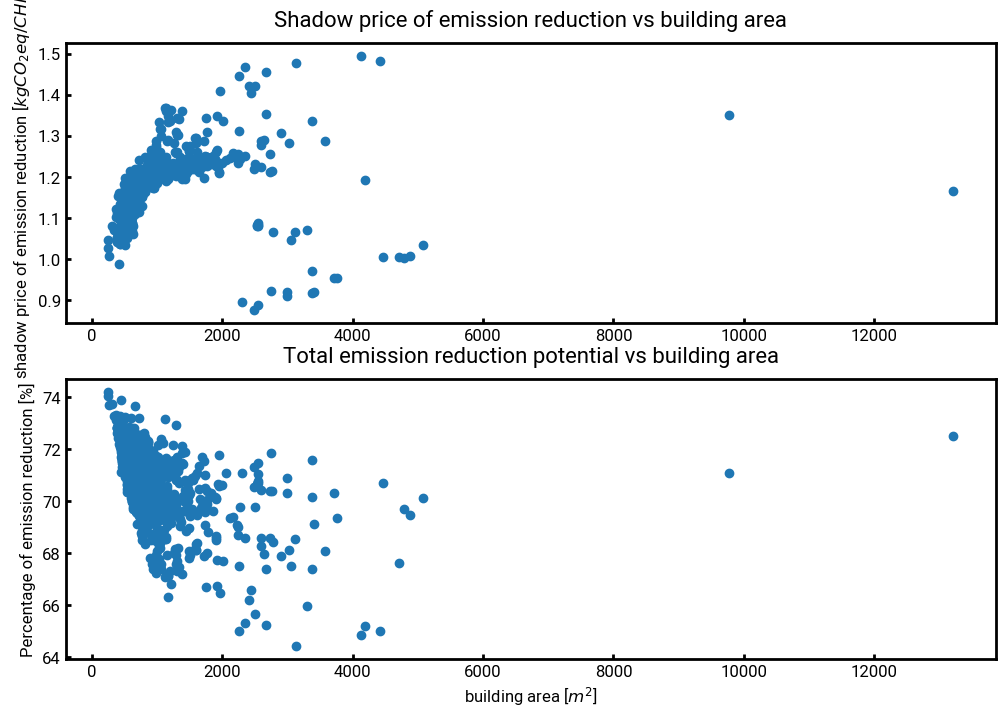

In [41]:
# plot both the shadow price and the relative emission reduction potential against building area
fig, axes = plt.subplots(2, 1)
axes[0].scatter(cluster_1["area"], cluster_1["shadow_price"])
axes[0].set_ylabel("shadow price of emission reduction [$kgCO_2eq/CHF$]")
axes[0].set_title("Shadow price of emission reduction vs building area")
axes[1].scatter(cluster_1["area"], cluster_1["emission_range_rel"] * 100)
axes[1].set_ylabel("Percentage of emission reduction [%]")
axes[1].set_xlabel("building area [$m^2$]")
axes[1].set_title("Total emission reduction potential vs building area")
plt.show()

year and area are both very important within clsuter 2, but they don't seem to be highly correlated. This is why both relative emission reduction and shadow price are distributed in a 2D space when plotting against both area and year.

### gradient boosting for second cluster in fig2

### parameter correlation in cluster 2

In [43]:
# calculate and visualize the corelation matrix of cluster_1_encoded
corr = cluster_1_encoded.corr()
fig, ax = plt.subplots()
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

NameError: name 'cluster_1_encoded' is not defined

In [ ]:
# plot the scatter plot of each parameter against each other to see the correlation visually using seaborn pairplot
sns.pairplot(cluster_1_encoded)
plt.show()

In [ ]:
x1_train_gbr, x1_test_gbr, y1_train_gbr, y1_test_gbr = train_test_split(
    x, y1, test_size=0.3, random_state=42
)
model = GradientBoostingRegressor(random_state=42)
model.fit(x1_train_gbr, y1_train_gbr)
y1_pred_gbr = model.predict(x1_test_gbr)
print(model.score(x1_test_gbr, y1_test_gbr))

mse_1_gbr = mean_squared_error(y1_test_gbr, y1_pred_gbr)
r2_1_gbr = r2_score(y1_test_gbr, y1_pred_gbr)
print(f"Mean squared error: {mse_1_gbr:.2f}, R2 score: {r2_1_gbr:.2f}")

feature_importance_1_gbr = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance_1_gbr["feature"], feature_importance_1_gbr["importance"])
plt.show()

residuals_1_gbr = y1_test_gbr - y1_pred_gbr
fig, ax = plt.subplots()
ax.scatter(y1_pred_gbr, residuals_1_gbr)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel("predicted shadow price from GBR")
ax.set_ylabel("residuals")
plt.show()

In [ ]:
x2_train_gbr, x2_test_gbr, y2_train_gbr, y2_test_gbr = train_test_split(
    x, y2, test_size=0.3, random_state=42
)
model = GradientBoostingRegressor(random_state=42)
model.fit(x2_train_gbr, y2_train_gbr)
y2_pred_gbr = model.predict(x2_test_gbr)
print(model.score(x2_test_gbr, y2_test_gbr))

mse_2_gbr = mean_squared_error(y2_test_gbr, y2_pred_gbr)
r2_2_gbr = r2_score(y2_test_gbr, y2_pred_gbr)
print(f"Mean squared error: {mse_2_gbr:.2f}, R2 score: {r2_2_gbr:.2f}")

feature_importance_2_gbr = pd.DataFrame(
    {"feature": x.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

fig, ax = plt.subplots()
ax.barh(feature_importance_2_gbr["feature"], feature_importance_2_gbr["importance"])
plt.show()

residuals_2_gbr = y2_test_gbr - y2_pred_gbr
fig, ax = plt.subplots()
ax.scatter(y2_pred_gbr, residuals_2_gbr)
ax.axhline(0, color="red", linestyle="--")
ax.set_xlabel(
    "predicted relative emission reduction potential from Gradient Boosting Regressor"
)
ax.set_ylabel("residuals")